In [1]:
import pickle, copy, json, os, h5py
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps
from random import shuffle
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
import la_forge.utils as lf_utils
lf_utils.set_publication_params({'text.usetex':False})
fig_dir = '/home/baierj/projects/hasasia2/hasasia2_paper/figures/'
#fig_dir = '/home/baierj/projects/hasasia2/pta_tuning/figures/'
os.chdir('/home/baierj/projects/hasasia2/pta_sensitivity_tuning/')

/home/baierj/anaconda3/envs/hasasia2/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [3]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as hutils
import hasasia.skymap as hsky
#from hasasia.utils import detection_prob as has_dp
# from hasasia.utils import false_dismissal_prob as has_fdpx
from hasasia.sensitivity import psd_from_background_realization as psd
#import holodeck as holo

In [4]:
import jax
jax.config.update("jax_enable_x64", True)

In [5]:
import scipy as sp
#(taken from holodeck)
def _func_line(xx, amp, slope):
    yy = amp + slope * xx
    return yy

def fit_powerlaw(xx, yy, init=[-15.0, -2.0/3.0]):
    """Fit the given data with a power-law.
    Returns
    -------
    log10_amp, plaw
    """
    popt, pcov = sp.optimize.curve_fit(_func_line, np.log10(xx), np.log10(yy), p0=init, maxfev=10000)
    # log10_amp = popt[0]
    # gamma = popt[1]

    def fit_func(xx, log10_amp, gamma):
        yy = _func_line(np.log10(xx), log10_amp, gamma)
        yy = 10.0 ** yy
        return yy

    return popt, fit_func

In [6]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord

# Setting various healpy quantities and GW source sky positions.
NSIDE = 1
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [7]:
snr_3sig = 3.7145
# from scipy import integrate
# fap3sigma = integrate.quad(lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2*x**2), 3, np.inf)[0]
F0_3sig = 8.898 #hutils._solve_F0_given_SNR(snr_3sig)
#print("false alarm rate for 3sigma: ", hutils.fap(F0_3sig))
print("F0 for 3sigma: ", F0_3sig)
print("S/N for 3sigma: ", snr_3sig)
# a fap of 0.0013 corresponds to a 3-sigma detection under a gaussian null distribution
# but here it corresponds to a S/N of 3.7145
# and a F0 of 8.898 for the hasasia detection statistic


F0 for 3sigma:  8.898
S/N for 3sigma:  3.7145


In [8]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]
def sky_ave_detect(sm,snr=snr_3sig):
    snr /= 2
    return snr*np.sqrt(np.mean(sm.S_eff,axis=1)/sm.Tspan)
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work
def sky_detect(sm,snr=snr_3sig):
    snr /= 2
    return snr*np.sqrt(sm.S_eff/sm.tspan)

In [9]:
fyr = 1/(365.25*24*3600)
days = 24*3600
yr_sec = 365.25*24*3600
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
## injecting GWB from 3P+ https://arxiv.org/pdf/2309.00693.pdf
# not included in paper, but these values are from Paul Baker 
# they are the 2D joint emperical distr. ---> gamma = 3.44; log10A = -14.29
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)
inj_gwb_hc = np.sqrt(hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)*freqs)

In [10]:
def get_sliced_spectra_old(psrs, cutoff,
                       Agwb=10**A_gwb, gw_gamma=gamma_gwb,
                       rn_psrs=None, thin=1,
                       sigma_correction=3,
                       psr_type='hasasia'):
    """
    Parameters 
    ----------
    
    psrs : list of enterprise.Pulsar or list of hasasia.Pulsar objects
        List of enterprise/hasasia Pulsar objects
        
    cutoff : float
        MJD cutoff for the calculation
        
    gwb : float, optional 
        Amplitude of the GW background. Keep as None if no GWB is desired.
        
    rn_psrs : dict, optional
        Dictionary where the keys are pulsar names and the values are 
        list of the red noise amplitude and spectral index (gamma). Keep
        as None if no RN is desired.
        
    thin : int, optional
        Amount of thinning to do for real data. `thin=1` is no thinning.
    
    sigma_correction : ?
        ???
    psr_type : str, optional
        Valid options: 'hasasia' or 'enterprise'.
        Set whether you are passing in `hsen.Pulsar` or `enterprise.Pulsar` objects.
    """
    psrs_cut = []
    psrs_copy = copy.deepcopy(psrs)
    
    for idx, ePsr in enumerate(psrs_copy):
        if psr_type == 'enterprise':
            #Cut the data to the requested length
            ePsr.filter_data(start_time=start_mjd, end_time=cutoff)

            #Make a simple diagonal correlation matrix
            corr = np.diag(sigma_correction*ePsr.toaerrs[::thin]**2)
            
            # Add autocorrelation noise from GWB into pulsar
            if Agwb is not None:
                plaw = hsen.red_noise_powerlaw(A=Agwb, gamma=gw_gamma, 
                                            freqs=freqs)
                corr += hsen.corr_from_psd(freqs=freqs, psd=plaw,
                                        toas=ePsr.toas[::thin])
            # Add RN to the pulsars that are in the list from the 11-year data paper
            if rn_psrs is not None and ePsr.name in rn_psrs.keys():
                Amp, gam = rn_psrs[ePsr.name]
                plaw = hsen.red_noise_powerlaw(A=Amp, gamma=gam, freqs=freqs)
                corr += hsen.corr_from_psd(freqs=freqs, psd=plaw,
                                        toas=ePsr.toas[::thin])
        #Make hasasia.Pulsar object
            psr = hsen.Pulsar(toas=ePsr.toas[::thin],
                          toaerrs=sigma_correction*ePsr.toaerrs[::thin],
                          phi=ePsr.phi,theta=ePsr.theta,
                          designmatrix=ePsr.Mmat[::thin,:],
                          N=corr)
            psr.name = ePsr.name
        # hasasia.Pulsars are already hasasia pulsars !
        elif psr_type == 'hasasia':
            psr = ePsr
        # those are the only choices
        else:
            ValueError(f"psr_type must be either 'hasasia' or 'enterprise' not {psr_type}.")
        #If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
        if (psr.toas.size ==0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
    #         idxs.append(idx)
            pass
        else:
            psrs_cut.append(psr)

        print('\rAdd PSR {0} complete \n'.format(psr.name),
              end='')
        
    timespan = hsen.get_Tspan(psrs_cut)
    spectra = []
    for p in psrs_cut:
        sp = hsen.Spectrum(p,freqs=freqs)
        sp.name = p.name
        _ = sp.NcalInv
        spectra.append(sp)
        
    return spectra

In [11]:
def get_sliced_spectra(psrs, 
                       start_mjd=1,
                       end_mjd = None,
                       ):
    """
    Parameters 
    ----------
    
    psrs : list of enterprise.Pulsar or list of hasasia.Pulsar objects
        List of enterprise/hasasia Pulsar objects
        
    cutoff : float
        MJD cutoff for the calculation
    
    sigma_correction : ?
        ???
    """
    psrs_cut = []
    psrs_copy = copy.deepcopy(psrs)
    for idx, psr in enumerate(psrs_copy):
        # filter the data around to the appropriate slice
        #print("N_toa = ", len(psr.toas))
        psr.filter_data(start_time=start_mjd, end_time=end_mjd)
        #print("after filter = ", len(psr.toas)) 
        # If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
        if (psr.toas.size == 0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
    #         idxs.append(idx)
            pass
        else:
            psrs_cut.append(psr)
    timespan = hsen.get_Tspan(psrs_cut)
    spectra = []
    for idx, p in enumerate(psrs_cut):
        sp = hsen.Spectrum(p,freqs=freqs)
        sp.name = p.name
        _ = sp.NcalInv
        #print(f"psr spectra {idx} is done")
        spectra.append(sp)
    print(f"PTA spectrum with {len(spectra)} psrs created.")
    return spectra

In [12]:
def apply_opt_camp(psrs, 
                   high_cad_idxs, 
                   low_cad_idxs, 
                   thin_high_cad,
                   thin_low_cad):
    for p, psr in enumerate(psrs):
        if p in high_cad_idxs:
            psrs[p].change_cadence(
                start_time=20*365.25, end_time=41*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_high_cad, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
        elif  p in low_cad_idxs:
            psrs[p].change_cadence(
                start_time=20*365.25, end_time=41*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_low_cad, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    return 0

# 1) Load `hsen.Pulsars` created in `creating_pta.ipynb` and binary simulations

In [13]:
proj_dir = '/home/baierj/projects/hasasia2/pta_tuning/'
#proj_dir = '.'
def reset_psrs_fullAmp():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'{proj_dir}/data/gpta_psrs_40yrs_v2/gpta_psr_{i}_v2.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` in from `creating_pta.ipynb`.")
    return gpta_psrs_40yrs
def reset_psrs():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'{proj_dir}/data/gpta_psrs_40yrs_v2_halfAmp/gpta_psr_{i}_v2_halfAmp.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` with half the GWB injected")
    return gpta_psrs_40yrs
gpta_psrs_40yrs_halfAmp = reset_psrs()
gpta_psrs_40yrs = reset_psrs_fullAmp()

Loaded  157  `hsen.Pulsars` with half the GWB injected
Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [14]:
unweighted_sigmas = np.array([4.34518856e-07, 3.97324530e-07, 6.25306787e-07, 1.34130112e-07,
       3.90101962e-07, 5.52324281e-07, 5.21365086e-07, 5.77405433e-07,
       4.52103376e-07, 7.21854779e-07, 1.61859269e-06, 2.94116573e-07,
       6.24232150e-07, 3.07853559e-07, 1.17952896e-06, 5.34561571e-07,
       6.90281801e-07, 3.61565718e-07, 3.20459534e-07, 5.93774686e-07,
       5.10433107e-07, 2.50755671e-06, 1.32521045e-06, 1.28874134e-06,
       1.92803093e-06, 2.21432255e-07, 6.71426801e-07, 7.18374875e-07,
       3.69499555e-06, 4.63231645e-07, 4.25080125e-07, 2.53568478e-07,
       1.26573261e-07, 2.34159916e-06, 9.76946563e-07, 1.36995656e-06,
       4.55219608e-07, 7.21289531e-07, 1.95039382e-07, 5.92130210e-07,
       5.49288698e-06, 1.69376752e-06, 5.00340069e-07, 3.66115606e-06,
       4.18631626e-07, 2.69122732e-06, 2.52249570e-06, 1.40257482e-06,
       8.26683042e-07, 1.68034269e-06, 4.63909251e-07, 1.53424624e-06,
       7.94683605e-07, 1.24060439e-07, 5.05572358e-07, 3.23790693e-07,
       5.80022741e-06, 5.87243347e-07, 6.00138151e-07, 8.50446173e-07,
       5.18050366e-07, 3.12560674e-07, 1.45745017e-06, 3.69100686e-07,
       6.16362527e-07, 4.11295707e-07, 2.45885492e-07, 1.60895486e-06,
       5.18608215e-06, 3.59412871e-06, 1.97436370e-06, 1.34471109e-06,
       4.96156204e-07, 2.18227739e-07, 5.41430815e-07, 4.19005157e-07,
       3.08259405e-07, 1.78580302e-07, 1.21709038e-06, 1.22658590e-07,
       1.33692644e-06, 3.22578694e-07, 2.16073847e-07, 2.30196761e-07,
       9.87464341e-07, 4.28323489e-07, 5.49715529e-07, 6.78742460e-07,
       1.59951073e-06, 1.22344006e-06, 4.46608936e-07, 3.07288234e-07,
       1.81516015e-07, 4.70622425e-07, 4.40510156e-07, 5.72523992e-07,
       1.04480211e-06, 1.09297969e-06, 4.56585407e-07, 5.24803843e-07,
       3.59156611e-07, 1.37776280e-06, 1.83770050e-07, 1.09837396e-06,
       1.35522007e-06, 1.35230016e-06, 4.38525905e-07, 5.21152680e-07,
       7.23087913e-07, 4.48478319e-07, 5.19393909e-07, 3.77548691e-07,
       5.74958145e-07, 1.65872889e-07, 1.40396920e-06, 6.19380009e-07,
       3.24885943e-07, 1.25622102e-07, 3.05302639e-07, 1.73242995e-06,
       3.94053989e-07, 1.20227823e-07, 1.93193292e-07, 1.27619788e-07,
       3.18992484e-07, 5.95613167e-07, 3.46313950e-06, 6.98844466e-07,
       7.27561592e-07, 5.63238211e-07, 6.31706322e-07, 6.51748219e-07,
       5.87923131e-07, 6.28118913e-07, 1.33005469e-06, 1.47433890e-06,
       2.14313979e-07, 2.34318016e-07, 1.00151280e-06, 5.47562108e-07,
       4.64952780e-07, 5.01761091e-07, 7.54266806e-07, 1.12049623e-06,
       1.29914769e-06, 2.88652276e-07, 4.48644040e-07, 4.42071570e-07,
       4.99513102e-07, 1.38001639e-06, 4.60977408e-07, 1.72544662e-07,
       5.59933540e-07, 1.39531076e-06, 5.09449330e-07, 7.30921220e-07,
       4.81412433e-07])
timespans = np.array([35.12220489, 27.52376839, 30.61358484, 32.19335777, 39.69199198,
       27.84951415, 30.97121053, 27.58934466, 30.19352916, 33.14840048,
       29.10992631, 28.33522001, 27.95412538, 32.72845017, 34.9117191 ,
       34.58603486, 39.79876208, 27.50308901, 34.24012713, 32.94500606,
       32.83648009, 39.85428066, 27.55964202, 34.92865686, 39.25918549,
       31.9037563 , 30.07274164, 36.66100955, 27.88044159, 31.25934142,
       32.04548596, 34.89336798, 27.85506703, 28.53649693, 31.0060101 ,
       33.15830638, 39.55168903, 33.11668926, 28.02500688, 39.92536802,
       39.49111827, 31.80475773, 39.69293604, 32.34484421, 39.69676021,
       39.32392204, 39.87629797, 39.68269723, 27.63612717, 28.1898967 ,
       30.83703605, 39.8118608 , 29.46672982, 28.13280126, 39.54907017,
       31.29413729, 39.63516992, 28.13185457, 34.43460361, 31.24519656,
       27.79759398, 34.92838743, 28.7559876 , 27.65042344, 27.73156517,
       27.73609246, 39.63460059, 35.53498217, 39.59600066, 34.59476859,
       32.17104345, 29.54901298, 39.99474825, 30.46703781, 31.48775986,
       30.69134417, 39.92116419, 28.1894432 , 29.98751993, 34.70326574,
       27.74459062, 33.00886955, 31.54362093, 29.16816083, 28.65556485,
       31.96949349, 30.54720582, 31.37496839, 30.12181196, 39.88510828,
       28.02491891, 27.87868944, 30.20443628, 32.85778263, 34.407487  ,
       30.90187408, 40.        , 30.32320026, 35.27685221, 33.29137693,
       39.25669167, 39.90798728, 39.56299638, 35.92678903, 34.9533288 ,
       30.09416207, 28.081782  , 27.74230904, 28.69455189, 31.18147454,
       32.07403954, 36.16488454, 39.83819743, 27.96058058, 27.9194032 ,
        1.        ,  1.        ,  2.00643501,  2.00643501,  3.01287003,
        3.01287003,  4.01930504,  4.01930504,  5.02574005,  5.02574005,
        6.03217507,  6.03217507,  7.03861008,  7.03861008,  8.0450451 ,
        8.0450451 ,  9.05148011,  9.05148011, 10.05791512, 10.05791512,
       11.06435014, 11.06435014, 12.07078515, 12.07078515, 13.07722016,
       13.07722016, 14.08365518, 14.08365518, 15.09009019, 15.09009019,
       16.0965252 , 16.0965252 , 17.10296022, 17.10296022, 18.10939523,
       18.10939523, 19.11583025, 19.11583025, 20.12226526, 20.12226526,
       21.12870027, 21.12870027])
# get the tspans, irn, etc.
tests_psr = gpta_psrs_40yrs[0]
tests_psr.phi
names = []
[names.append(gpta_psrs_40yrs[i].name) for i in range(len(gpta_psrs_40yrs))]
phis = []
[phis.append(gpta_psrs_40yrs[i].phi) for i in range(len(gpta_psrs_40yrs))]
thetas = []
[thetas.append(gpta_psrs_40yrs[i].theta) for i in range(len(gpta_psrs_40yrs))]
A_rn = []
[A_rn.append(gpta_psrs_40yrs[i].A_rn) for i in range(len(gpta_psrs_40yrs))]
alpha_rn = []
[alpha_rn.append(gpta_psrs_40yrs[i].alpha) for i in range(len(gpta_psrs_40yrs))]
tuned_sigmas = 1.13*unweighted_sigmas*np.sqrt(np.pi)
sigmas = []
[sigmas.append(gpta_psrs_40yrs[i].toaerrs[0]) for i in range(len(gpta_psrs_40yrs))]
len(names), len(phis), len(thetas), len(A_rn), len(alpha_rn), len(sigmas)
def sim_pta_w_inj_gwb(A_gwb, alpha_gwb):
    print(f"Creaing array of {len(names)} psrs with injected A_gwb: {np.log10(A_gwb)} and alpha_gwb: {alpha_gwb:.2f} ...")
    return hsim.sim_pta(timespan=timespans, # need units to be years
                psr_names=names,
                cad=20,
                sigma=np.array(sigmas),#1.13*unweighted_sigmas*np.sqrt(np.pi),#*np.sqrt(np.pi), # the sqrt(pi) is DMX transmission function and the 1.13 is like efac or something
                A_rn=A_rn,
                alpha=alpha_rn,
                freqs=freqs,
                A_gwb=A_gwb,
                #gamma_gwb=-2/3,
                gamma_gwb=gamma_gwb,
                phi=phis,
                theta=thetas,
                uneven=True)

## Sam lib data
### used with permission from Emiko Gardiner
Description: 500 samples (drawn from a uniform param space similar to the one in the awg paper), each of which have 100 realizations. sorted them by how well they match the 1/10yr 15yr GWB characteristic strain detection, cuz at that frequency the strain amplitude and spectral index are pretty covariant. Ranking from best to worst sample is in the npz array, but the 10 best are, in order
202 103 452 111 117  79 180 276 245 479

the hc_bg and hc_ss in the hdf file are shaped (nsamples, nfreqs, nreals) and (nsamples, nfreqs, nreals, nloudest)
## hc_bg:(nsamples, nfreqs, nreals)
## hc_ss: (nsamples, nfreqs, nreals, nloudest) 

In [15]:
# data used with permission from Emiko Gardiner
ssfile = h5py.File('/home/baierj/projects/hasasia2/extra_data/sam_lib.hdf5', 'r') 
hc_bg = ssfile['hc_bg'][202,...]
hc_ss = ssfile['hc_ss'][202,...]
fobs = ssfile['fobs'][:]
ssfile.close()
dfobs=np.ones(len(fobs))*(fobs[1]-fobs[0])
silver = '#cebebe'
dots = '#E55812'
#thankfully fobs is evenly spaced. so dfobs is just the difference between first and second freq bin

In [16]:
print("The 202nd sample:")
print("fobs: ",len(fobs))
print("hc_bg: ", hc_bg.shape)
print("hc_ss: ", hc_ss.shape)

The 202nd sample:
fobs:  40
hc_bg:  (40, 100)
hc_ss:  (40, 100, 5)


In [17]:
np.random.seed(0)
random_samples = np.array([int(np.rint(i)) for i in np.random.uniform(0,499,10)])
random_samples

array([274, 357, 301, 272, 211, 322, 218, 445, 481, 191])

In [18]:
# data used with permission from Emiko Gardiner
mult_hc_bg = []
mult_new_bgs = []
mult_hc_ss = []
mult_c_i = []
realization_per_sample = 100
for s in random_samples:
    ssfile = h5py.File('/home/baierj/projects/hasasia2/extra_data/sam_lib.hdf5', 'r') 
    hc_bg = ssfile['hc_bg'][s,...][:, ::1]
    hc_ss = ssfile['hc_ss'][s,...][:,::1,:]
    ssfile.close()
    # can either think about the background as being the binaries including the foreground
    new_hc_bg = np.sqrt(hc_bg**2 + np.sum(hc_ss[:,:,:]**2, axis=-1))
    # or not including the foreground
    #new_hc_bg = hc_bg
    c_i = np.sqrt((10**A_gwb)**2*(fobs/fyr)**(2*alpha_gwb)/np.quantile(new_hc_bg,0.5,axis=-1)**2)
    cis = np.array([c_i for _ in range(realization_per_sample)]).T
    mult_hc_bg.append(hc_bg)
    mult_new_bgs.append(new_hc_bg)
    mult_c_i.append(cis)
    mult_hc_ss.append(hc_ss)
hc_bg = np.concatenate(mult_hc_bg, axis=1)
# this factor of 5 is empirically determined to adjust our populations
# to have an appropriate loudness at year 30 or so.
# we do to to get a dynamical range of detection probability to tune our pta in
hc_ss = np.concatenate(mult_hc_ss,axis=1)/5.
c_i = np.concatenate(mult_c_i, axis=1)
new_hc_bg =np.concatenate(mult_new_bgs, axis=1)
hc_bg.shape, hc_ss.shape, c_i.shape, new_hc_bg.shape

((40, 1000), (40, 1000, 5), (40, 1000), (40, 1000))

In [19]:
hc_ss[:,:,1:].shape, hc_ss.shape

((40, 1000, 4), (40, 1000, 5))

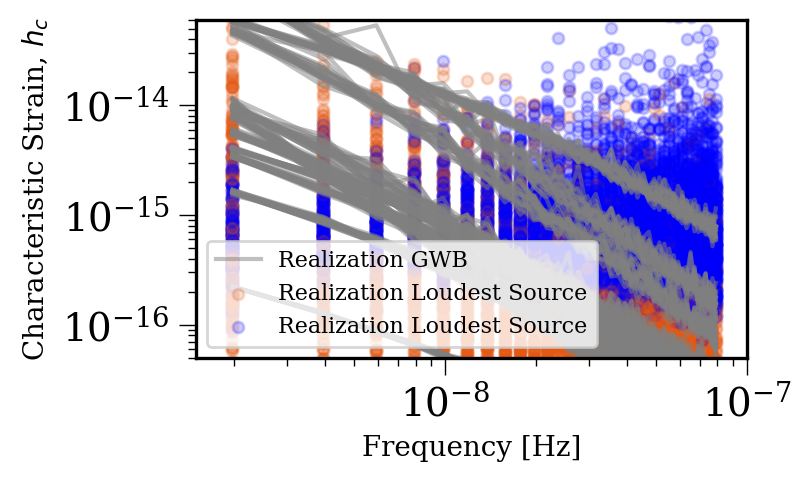

In [20]:
YR=365.25*24*3600
nreals = 1000#np.min([100, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals)[::5]:
    if(rr==0):
        label_bg = 'Realization GWB'
        label_ss = 'Realization Loudest Source'
    else:
        label_bg = None
        label_ss = None
    plt.loglog(fobs, hc_bg[:,rr], alpha=0.5, label=label_bg, color="grey")#color=colors[rr])
    plt.scatter(fobs, hc_ss[:,rr,0], alpha=0.2, label=label_ss, color=dots)#color=colors[rr])
    plt.scatter(fobs, c_i[:,rr]*hc_ss[:,rr,0], alpha=0.2, label=label_ss, color='blue')#color=colors[rr])
plt.xlim(1.5e-9, 1e-7)
plt.ylim(0.5e-16, 0.6e-13)
#plt.loglog(fobs, np.median(hc_bg, axis=1), color='k')
plt.legend(fontsize=8,loc=3)
plt.show()

In [21]:
# fit simple powerlaws to first n_bins of the populations
n_bins = 20
amps = []
alphs = []
for i in range(1000):
    (fit_amp, fit_alph), _ = fit_powerlaw(fobs[:n_bins], new_hc_bg.T[i][:n_bins])
    amps.append(fit_amp)
    alphs.append(fit_alph)
_, fit_func = fit_powerlaw(fobs[:n_bins], new_hc_bg.T[0][:n_bins])
amps_wo = []
alphs_wo = []
for i in range(1000):
    (fit_amp, fit_alph), _ = fit_powerlaw(fobs[:n_bins], hc_bg.T[i][:n_bins])
    amps_wo.append(fit_amp)
    alphs_wo.append(fit_alph)
_, fit_func_wo = fit_powerlaw(fobs[:n_bins], hc_bg.T[0][:n_bins])
amps_adj = []
alphs_adj = []
for i in range(1000):
    (fit_amp, fit_alph), _ = fit_powerlaw(fobs[:n_bins], (c_i[:,i]*new_hc_bg.T[i])[:n_bins])
    amps_adj.append(fit_amp)
    alphs_adj.append(fit_alph)
_, fit_func_adj = fit_powerlaw(fobs[:n_bins], (c_i[:,i]*new_hc_bg.T[0])[:n_bins])

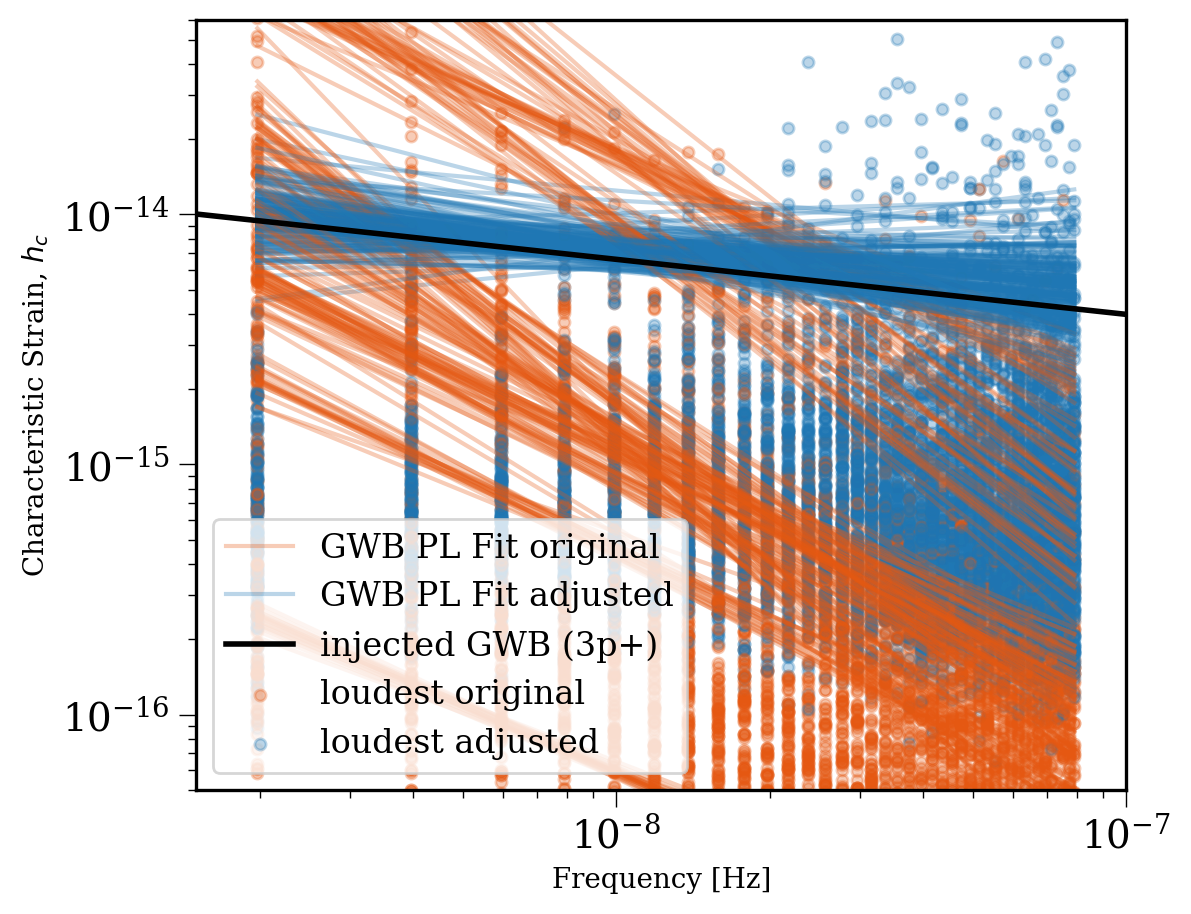

In [22]:
#compare NG15y like population to 3p+ like population
fig=plt.figure(figsize=(6,5))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
for i in range(1000)[::5]:    
    plt.loglog(fobs, fit_func(fobs, amps[i], alphs[i]),color=dots,alpha=0.3 )
    plt.loglog(fobs, fit_func_adj(fobs, amps_adj[i], alphs_adj[i]),color='C0',alpha=0.3 )
    plt.scatter(fobs, hc_ss[:,i,0], alpha=0.3, color=dots, zorder=0)#color=colors[rr])
    plt.scatter(fobs, c_i[:,i]*hc_ss[:,i,0], alpha=0.3, color='C0', zorder=0)#color=colors[rr])
    #plt.loglog(fobs, new_hc_bg[:,i], alpha=0.1, color="purple")#color=colors[rr])
plt.loglog(fobs, fit_func(fobs, amps[i], alphs[i]), label= 'GWB PL Fit original', color=dots,alpha=0.3 )
plt.loglog(fobs, fit_func_adj(fobs, amps_adj[i], alphs_adj[i]),color='C0',alpha=0.3, label='GWB PL Fit adjusted')
plt.loglog(freqs, inj_gwb_hc, color='black', alpha=1, linewidth=2, label='injected GWB (3p+)')
plt.scatter(fobs, hc_ss[:,i,0], alpha=0.3, color=dots, zorder=0, label='loudest original')#color=colors[rr])
plt.scatter(fobs, c_i[:,i]*hc_ss[:,i,0], alpha=0.3, color='C0', zorder=0, label='loudest adjusted')#color=colors[rr])
plt.xlim(1.5e-9, 1e-7)
plt.ylim(0.5e-16, 0.6e-13)
#plt.loglog(fobs, np.median(hc_bg, axis=1), color='k')
plt.legend(fontsize=12,loc=3)
plt.show()

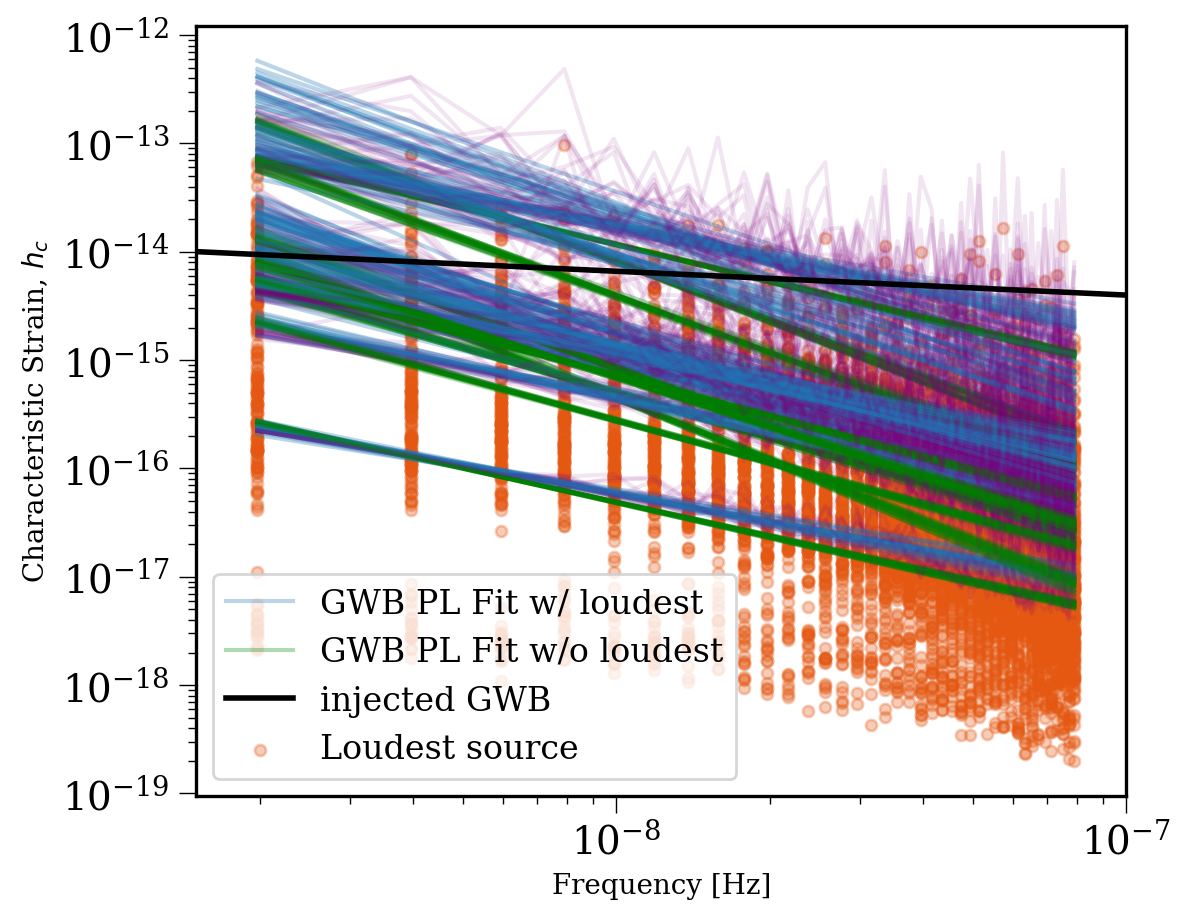

In [23]:
fig=plt.figure(figsize=(6,5))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
for i in range(1000)[::5]:    
    plt.loglog(fobs, fit_func(fobs, amps[i], alphs[i]),color='C0',alpha=0.3 )
    plt.loglog(fobs, fit_func_wo(fobs, amps_wo[i], alphs_wo[i]),color='green',alpha=0.3 )
    plt.scatter(fobs, hc_ss[:,i,0], alpha=0.3, color=dots, zorder=0)#color=colors[rr])
    plt.loglog(fobs, new_hc_bg[:,i], alpha=0.1, color="purple")#color=colors[rr])
plt.loglog(fobs, fit_func(fobs, amps[i], alphs[i]), label= 'GWB PL Fit w/ loudest', color='C0',alpha=0.3 )
plt.loglog(fobs, fit_func_wo(fobs, amps_wo[i], alphs_wo[i]),color='green',alpha=0.3, label='GWB PL Fit w/o loudest')
plt.loglog(freqs, inj_gwb_hc, color='black', alpha=1, linewidth=2, label='injected GWB')
plt.scatter(fobs, hc_ss[:,i,0], alpha=0.3, color=dots, zorder=0, label='Loudest source')#color=colors[rr])
plt.xlim(1.5e-9, 1e-7)
#plt.ylim(0.5e-16, 0.6e-13)
#plt.loglog(fobs, np.median(hc_bg, axis=1), color='k')
plt.legend(fontsize=12,loc=3)
plt.show()

In [24]:
# take one slice every year from NG15 to the end of the data set (40yrs)
start = 16
end = 40
slice_cad = 1
yearly_years = np.linspace(start, end, (end-start)*slice_cad+1)
yearly_years

array([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.])

In [26]:
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

In [27]:
yearly_spectra = []
yearly_GWBSC = []
yearly_SNR = []
#gpta_psrs_40yrs =  sim_pta_w_inj_gwb(10**A_gwb/2, alpha_gwb)
gpta_psrs_40yrs = reset_psrs_fullAmp()
#gpta_psrs_40yrs = reset_psrs()
for year in yearly_years:
    #print("got first spectra")
    yearly_spectra.append(
        get_sliced_spectra(
            psrs=gpta_psrs_40yrs,
            start_mjd=-1000,
            end_mjd=365.25*year
        )
    )
    yearly_GWBSC.append(hsen.GWBSensitivityCurve(spectra=yearly_spectra[-1], orf='hd', autocorr=False))
    yearly_SNR.append(yearly_GWBSC[-1].SNR(S_h))

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 117 psrs created.
PTA spectrum with 119 psrs created.
PTA spectrum with 121 psrs created.
PTA spectrum with 123 psrs created.
PTA spectrum with 125 psrs created.
PTA spectrum with 127 psrs created.
PTA spectrum with 129 psrs created.
PTA spectrum with 131 psrs created.
PTA spectrum with 133 psrs created.
PTA spectrum with 135 psrs created.
PTA spectrum with 137 psrs created.
PTA spectrum with 139 psrs created.
PTA spectrum with 141 psrs created.
PTA spectrum with 143 psrs created.
PTA spectrum with 144 psrs created.
PTA spectrum with 145 psrs created.
PTA spectrum with 148 psrs created.
PTA spectrum with 149 psrs created.
PTA spectrum with 152 psrs created.


In [28]:
yearly_spectra2 = []
yearly_GWBSC2 = []
yearly_SNR2 = []
#gpta_psrs_40yrs =  sim_pta_w_inj_gwb(10**A_gwb/2, alpha_gwb)
#gpta_psrs_40yrs = reset_psrs_fullAmp()
gpta_psrs_40yrs = reset_psrs()
for year in yearly_years:
    #print("got first spectra")
    yearly_spectra2.append(
        get_sliced_spectra(
            psrs=gpta_psrs_40yrs,
            start_mjd=-1000,
            end_mjd=365.25*year
        )
    )
    yearly_GWBSC2.append(hsen.GWBSensitivityCurve(spectra=yearly_spectra2[-1], orf='hd', autocorr=False))
    yearly_SNR2.append(yearly_GWBSC2[-1].SNR(S_h))

Loaded  157  `hsen.Pulsars` with half the GWB injected
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 117 psrs created.
PTA spectrum with 119 psrs created.
PTA spectrum with 121 psrs created.
PTA spectrum with 123 psrs created.
PTA spectrum with 125 psrs created.
PTA spectrum with 127 psrs created.
PTA spectrum with 129 psrs created.
PTA spectrum with 131 psrs created.
PTA spectrum with 133 psrs created.
PTA spectrum with 135 psrs created.
PTA spectrum with 137 psrs created.
PTA spectrum with 139 psrs created.
PTA spectrum with 141 psrs created.
PTA spectrum with 143 psrs created.
PTA spectrum with 144 psrs created.
PTA spectrum with 145 psrs created.
PTA spectrum with 147 psrs created.
PTA spectrum with 149 psrs created.
PTA spectrum with 152 psrs created.


In [29]:
sky_maps = [hsky.SkySensitivity(spectra=spectrum, theta_gw=theta_gw, phi_gw=phi_gw) for spectrum in yearly_spectra]
sky_maps2 = [hsky.SkySensitivity(spectra=spectrum, theta_gw=theta_gw, phi_gw=phi_gw) for spectrum in yearly_spectra2]

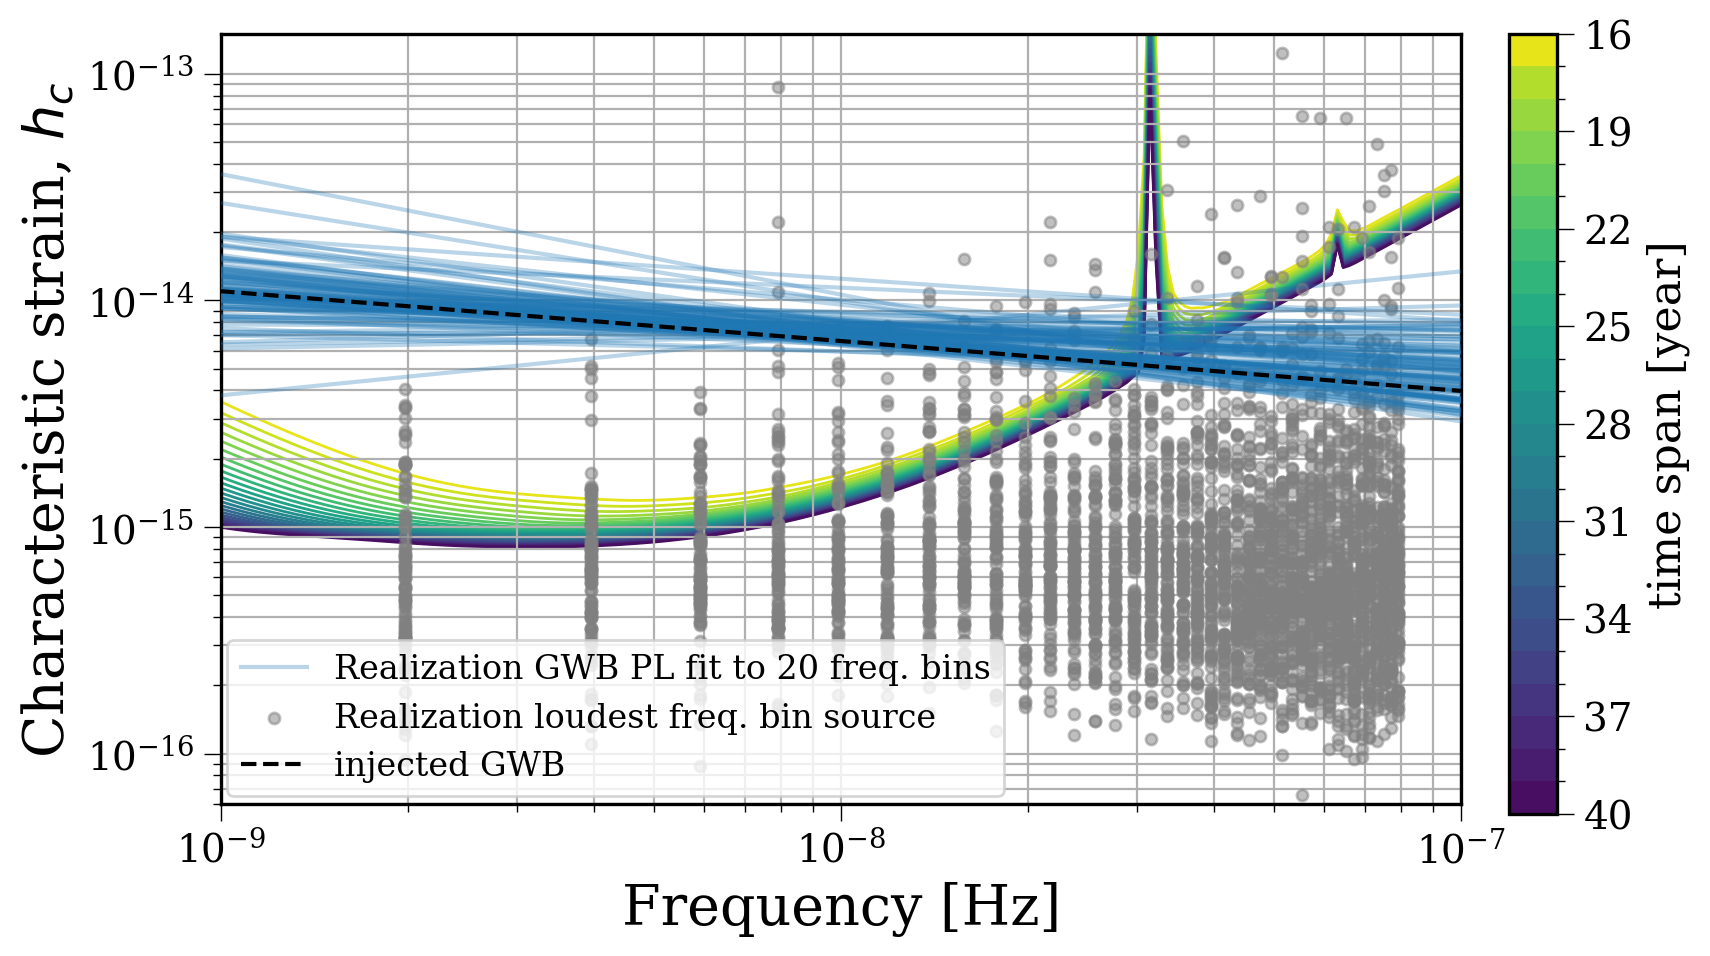

In [30]:
# Plot GWB SC with realizations on it
#color_map = plt.cm.jet_r(np.linspace(0,1,len(yearly_years)))
color_map = sns.color_palette('viridis_r', n_colors = len(yearly_years), as_cmap=False,)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
fig = plt.figure(figsize=[8,5])
plt.grid(which='both',zorder=0)
for i, sc in enumerate(sky_maps):
    linewidth=1
    # if yearly_years[i] == yearly_years[-1] or yearly_years[i]==yearly_years[0]:
    #     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"{yearly_years[i]:.1f}yr->GWB S/N:{yearly_SNR[i]:.2f}", color = color_map[i], linewidth=linewidth, alpha=1, zorder=5)
    # else:
    plt.loglog(sc.freqs, sc.h_c.mean(axis=1), color = color_map[i], linewidth=linewidth, alpha=1,zorder=1)
    #plt.loglog(sc.freqs, sky_ave_detect(sc), color = color_map[i], linewidth=linewidth, alpha=1,zorder=1) 
for rr in range(len(hc_bg[0]))[::10]:
    if(rr==0):
        label_bg = 'Realization GWB PL fit to 20 freq. bins'
        label_ss = 'Realization loudest freq. bin source'
    else:
        label_bg = None
        label_ss = None
    #plt.loglog(fobs, new_hc_bg[:,rr], alpha=0.1, label=label_bg_new, color="purple", zorder=502)#color=colors[rr])
    plt.loglog(freqs, fit_func_adj(freqs, amps_adj[rr], alphs_adj[rr]), label=label_bg, color='C0',alpha=0.3,zorder=4)
    #plt.loglog(fobs, hc_bg[:,rr], alpha=0.5, label=label_bg, color="grey", zorder=501)#color=colors[rr])
    plt.scatter(fobs, (c_i[:,rr]*hc_ss[:,rr,0]), alpha=0.5, label=label_ss, color='gray', zorder=2)#color=colors[rr])
plt.loglog(freqs, inj_gwb_hc, color='k', linestyle='--', label='injected GWB', zorder=5 )
plt.legend(loc=(0.005,0.01), fontsize=12)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain, $h_c$', fontsize=20)
#plt.title('GPTA Sky-Aved. Sensitivity', fontsize = 24)
plt.xlim((1e-9, 1e-7))
#plt.ylim((4e-16, 1e-13))
plt.ylim((.6e-16, 1.5e-13))
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(yearly_years), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(yearly_years))
ax2.set_ylabel('time span [year]', fontsize=16, labelpad=5)
#plt.savefig(f'{fig_dir}/GPTA_40yr_hc_evolution_w_sims_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [32]:
# # Plot GWB SC with realizations on it
# #color_map = plt.cm.jet_r(np.linspace(0,1,len(yearly_years)))
# color_map = sns.color_palette('viridis_r', n_colors = len(yearly_years), as_cmap=False,)
# plt.figure(figsize=[8,5])
# nreals = np.min([100, len(hc_bg[0])])
# colors = cm.rainbow(np.linspace(0,1,nreals))
# for i, sc in enumerate(sky_maps):
#     linewidth=1
#     # if yearly_years[i] == yearly_years[-1] or yearly_years[i]==yearly_years[0]:
#     #     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"{yearly_years[i]:.1f}yr->GWB S/N:{yearly_SNR[i]:.2f}", color = color_map[i], linewidth=linewidth, alpha=1, zorder=5)
#     # else:
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1,)
# for rr in range(nreals):
#     if(rr==0):
#         label_bg = 'Realization GWB'
#         label_ss = 'Realization Loudest Source'
#     else:
#         label_bg = None
#         label_ss = None
#     plt.loglog(fobs, hc_bg[:,rr], alpha=0.5, label=label_bg, color="grey", zorder=501)#color=colors[rr])
#     plt.scatter(fobs, hc_ss[:,rr,0], alpha=0.5, label=label_ss, color=dots, zorder=500)#color=colors[rr])
# plt.legend(loc='lower left', fontsize=10,)
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('Characteristic strain, $h_c$', fontsize=16)
# #plt.title('GPTA Sky-Aved. Sensitivity', fontsize = 24)
# plt.xlim((1.5e-9, 1e-7))
# plt.ylim((1e-16, 6e-13))
# plt.grid(which='both')
# plt.savefig(f'{fig_dir}/GPTA_40yr_hc_evolution_w_sims.png', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()

In [33]:
# #this line gets the SM index of the data set frequency bins (this is the same for all realizations)
# freq_indcs = np.array([np.argmin(abs(freqs-fobs[ii])) for ii in range(len(fobs))])
# # gets the indices of the best and worst sky position (at the first frequency)
# idx_of_worst_sky_position = np.argmax(sky_maps[14].S_effSky[0])
# idx_of_best_sky_position = np.argmin(sky_maps[14].S_effSky[0])
# yearly_years[14]

In [31]:
hc_ss.shape, c_i.shape

((40, 1000, 5), (40, 1000))

In [32]:
# convert our characteristic strain to strain amplitude
out_of_order_array = np.array([np.array([hutils.char_strain_to_strain_amp(c_i[:,realization]*hc_ss[:,realization, loudest], fobs, dfobs) for loudest in range(len(hc_ss[0,0,:]))]) for realization in range(len(hc_ss[0,:,0]))])
h_amp_ss = np.swapaxes(out_of_order_array, 0,1).T
h_amp_ss.shape

(40, 1000, 5)

In [36]:
# yearly_years[14]

In [33]:
# # this calculates the snr at two specific sky locations across all frequency bins for all the realizations
# # note that the factor of 2 difference is included here !!!!! don't double count it elsewhere.
# #the idx 14 corresponds to 30years. if you change the yearly_years, you need to change this.
freq_bin_idxs = sky_maps[0].fidx(fobs)
# best_sky_loc_snr=0.5*np.array([[sky_maps[14].SNR(h_amp_ss[inx,realization,0])[freq_bin_idxs[inx],idx_of_best_sky_position] for inx in range(len(fobs))] for realization in range(len(h_amp_ss[0]))]).T
# worst_sky_loc_snr=0.5*np.array([[sky_maps[14].SNR(h_amp_ss[inx,realization,0])[freq_bin_idxs[inx],idx_of_worst_sky_position] for inx in range(len(fobs))] for realization in range(len(h_amp_ss[0]))]).T


In [34]:
# best_sky_loc_snr[7][88]/worst_sky_loc_snr[7][88]
# # we can only do double axes for best/worst sky loc. for a single frequency.
# # the multiplicative factor is different for the different frequency bins !!
# # intuitively, this makes sense because there should be some sky dependence//frequency are not independent.
# # since our high frequency sensitivity is dominated by our best pulsar(s) which are at specific locations on the sky!

In [35]:
# for scat in range(len(best_sky_loc_snr[0,:])):
#     plt.scatter(fobs, best_sky_loc_snr[:, scat],alpha=0.5, color='teal')
# #plt.legend()
# plt.ylim(-0.1, 4.5)
# plt.ylabel('S/N at best sky location')
# plt.xlabel("Frequency [Hz]")
# #plt.twinx()
# #plt.axhline(1, color="black")
# plt.xscale('log')
# plt.xlim(1e-9, 1e-7)
# #plt.ylabel('S/N at worst sky location')
# #plt.ylim(-0.1/best_worst_sky_loc_ratio, 4.5/best_worst_sky_loc_ratio)
# #plt.yticks(range(0, 5))
# plt.show()

In [36]:
# snr = np.array([[0.5*sky_maps[0].SNR(h_amp_ss[inx,realization,0])[freq_bin_idxs[inx],:] for inx in range(len(fobs))] for realization in range(len(h_amp_ss[0]))]).T
# snr.shape

In [34]:
h_amp_ss.shape

(40, 1000, 5)

In [38]:
# gridded = sky_maps[14].sky_ave_SNR_gridded(
#     np.linspace(0, np.pi, 250),
#     np.linspace(-np.pi/4, np.pi/4, 250),
#     freq_bin_idxs
#     )

In [31]:
len(h_amp_ss[0,:,0])

1000

In [35]:
def parallel_TDP(sky_maps):
    gridded = sky_maps.sky_ave_SNR_gridded(
        np.linspace(0, np.pi, 100),
        np.linspace(-np.pi/4, np.pi/4, 100),
        freq_bin_idxs
    )
    return [sky_maps.total_detection_probability(
                         F_thresh=8.89,
                         ave='prob',
                         prob_kwargs={
                             'h0':h_amp_ss[:, it, 0],
                             'fidx':freq_bin_idxs,
                             'int_method':'trapz',
                             'snr_grid': gridded}) 
       for it in range(0, len(h_amp_ss[0, :, 0]))]

In [36]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    results = np.array(pool.map(parallel_TDP, sky_maps ))
results.shape


/home/baierj/anaconda3/envs/hasasia2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(25, 1000)

In [37]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    results2 = np.array(pool.map(parallel_TDP, sky_maps2 ))
results2.shape

(25, 1000)

In [38]:
legs = [mpl.patches.Patch(color='C0', label="w/ GWB fit" ),
        mpl.patches.Patch(color='C1', label="w/o GWB fit" ),
        mpl.lines.Line2D([0], [0], color='grey', markeredgecolor=None, linestyle='', marker='^', markersize=7, 
                         label = "mean"),
        mpl.lines.Line2D([0], [0], color='grey', markeredgecolor=None, linestyle='', marker='.', markersize=10,
                         label = 'median'),
        ]

### plotting the middle 68%

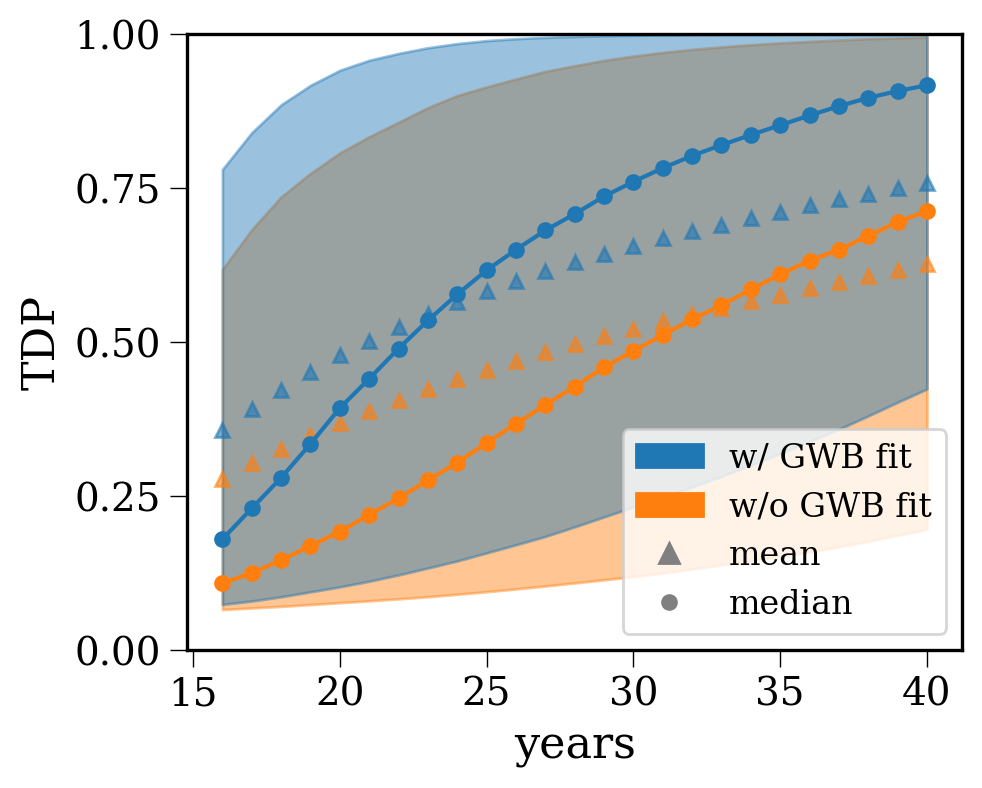

In [41]:
#### middle 68% CI
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
plt.xlabel('years',fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0])
plt.ylabel('TDP', fontsize=16)
plt.ylim(0,1)
#plt.axhline(y=0.95, linestyle='--', color = 'k', linewidth=1.5)
plt.ylim(bottom=0)
plt.plot(yearly_years, np.mean(results, axis=1), marker="^", markersize=5, label='mean', color='C1', linestyle='',alpha=0.6)
plt.plot(yearly_years, np.median(results, axis=1), marker=".", markersize=10, color='C1', linestyle='-', label='median')
plt.fill_between(yearly_years, np.quantile(results, q=.50+.32, axis=1), 
                        np.quantile(results, q=.50-.32, axis=1), alpha=0.45,label='without GWB sub 1$\sigma$', color='C1')
plt.plot(yearly_years, np.mean(results2, axis=1), marker="^", markersize=5, label='mean', color='C0', linestyle='',alpha=0.6)
plt.plot(yearly_years, np.median(results2, axis=1), marker=".", markersize=10, color='C0', linestyle='-', label='median')
plt.fill_between(yearly_years, np.quantile(results2, q=.50+.32, axis=1), 
                        np.quantile(results2, q=0.5-0.32, axis=1), alpha=0.45,label='with GWB sub 1$\sigma$', color='C0')
plt.legend(handles=legs, fontsize=12)
plt.savefig(f'{fig_dir}/GPTA_40yr_total_dp_evolution_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### plotting the upper 68% 

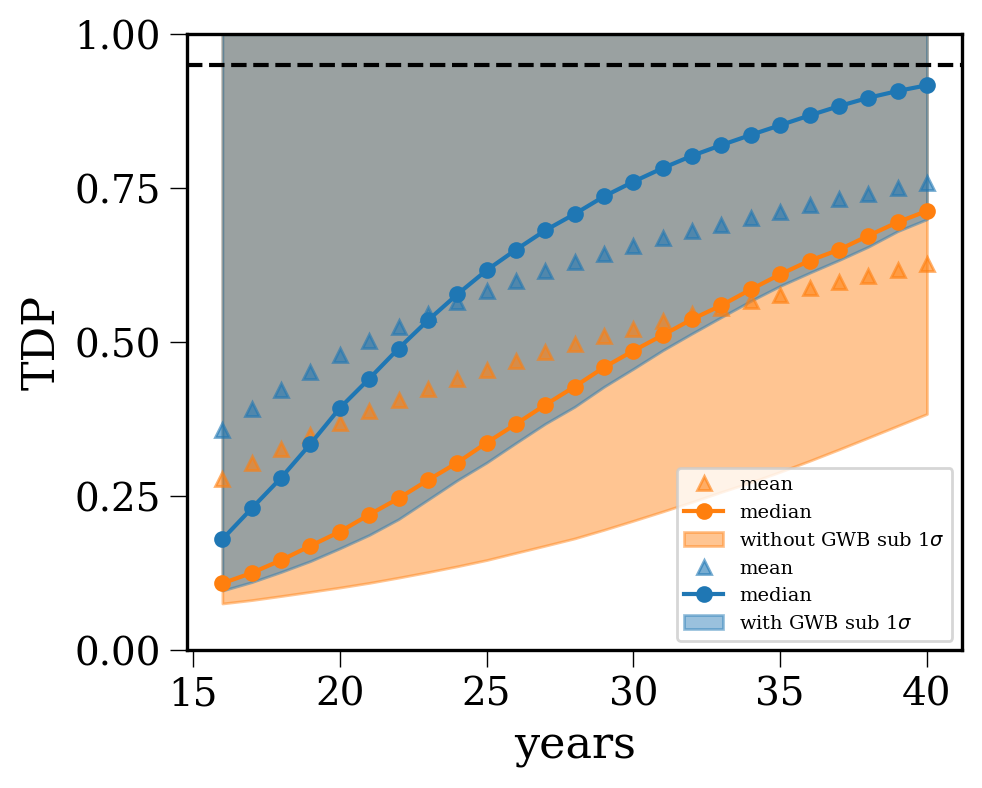

In [ ]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
plt.xlabel('years',fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0])
plt.ylabel('TDP', fontsize=16)
plt.ylim(0,1)
plt.ylim(bottom=0)
plt.plot(yearly_years, np.mean(results, axis=1), marker="^", markersize=5, label='mean', color='C1', linestyle='',alpha=0.6)
plt.plot(yearly_years, np.median(results, axis=1), marker=".", markersize=10, color='C1', linestyle='-', label='median')
plt.fill_between(yearly_years, np.quantile(results, q=1, axis=1), 
                        np.quantile(results, q=0.32, axis=1), alpha=0.45,label='without GWB sub 1$\sigma$', color='C1')
plt.plot(yearly_years, np.mean(results2, axis=1), marker="^", markersize=5, label='mean', color='C0', linestyle='',alpha=0.6)
plt.plot(yearly_years, np.median(results2, axis=1), marker=".", markersize=10, color='C0', linestyle='-', label='median')
plt.fill_between(yearly_years, np.quantile(results2, q=1, axis=1), 
                        np.quantile(results2, q=0.32, axis=1), alpha=0.45,label='with GWB sub 1$\sigma$', color='C0')
#plt.savefig(f'{fig_dir}/GPTA_40yr_bg_sub_total_dp_evolution_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.legend()
plt.show()
plt.close()

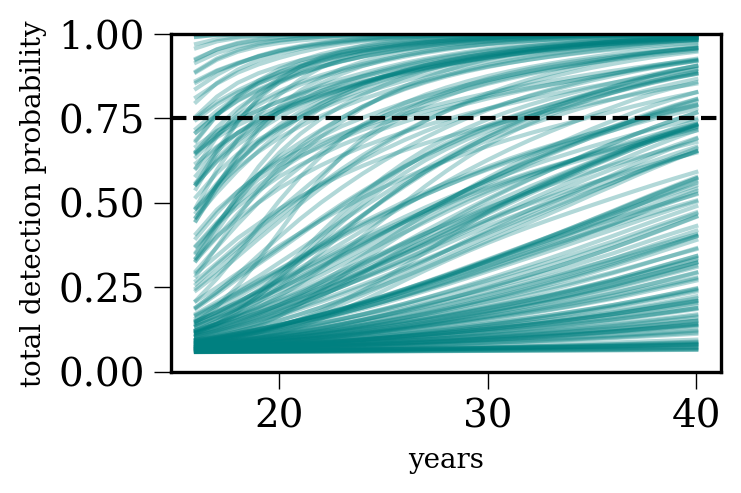

In [67]:
for realization in range(1000)[::5]:
    plt.plot(yearly_years, np.array(results)[:,realization], color = 'teal', alpha=0.3)
plt.xlabel('years')
plt.ylabel('total detection probability')
plt.ylim(0,1)
plt.axhline(y=0.75, linestyle='--', color = 'k', linewidth=1.5)
#plt.savefig(f'{fig_dir}/GPTA_40yr_bg_sub_total_dp_evolution.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [68]:
detec = [np.sum(np.array(results)[yr]>0.95)/10 for yr, year in enumerate(yearly_years)]

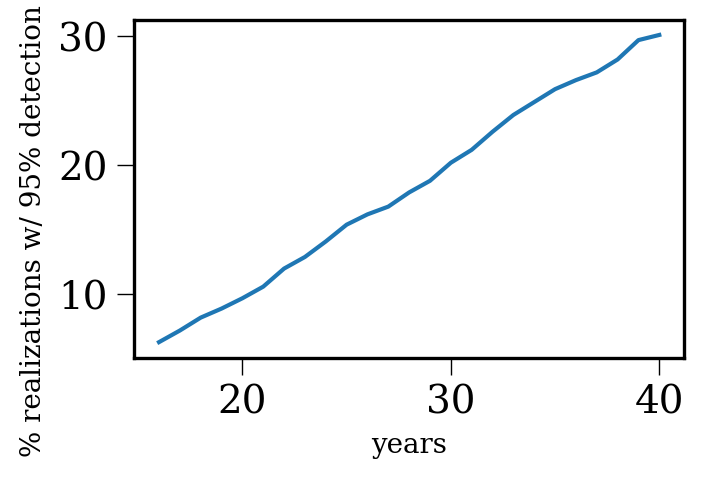

In [69]:
plt.plot(yearly_years, detec)
plt.xlabel('years')
plt.ylabel('% realizations w/ 95% detection prob.')
#plt.axhline(y=0.75, linestyle='--', color = 'k', linewidth=1.5)
#plt.savefig(f'{fig_dir}/GPTA_40yr_total_dp_percent_evolution.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

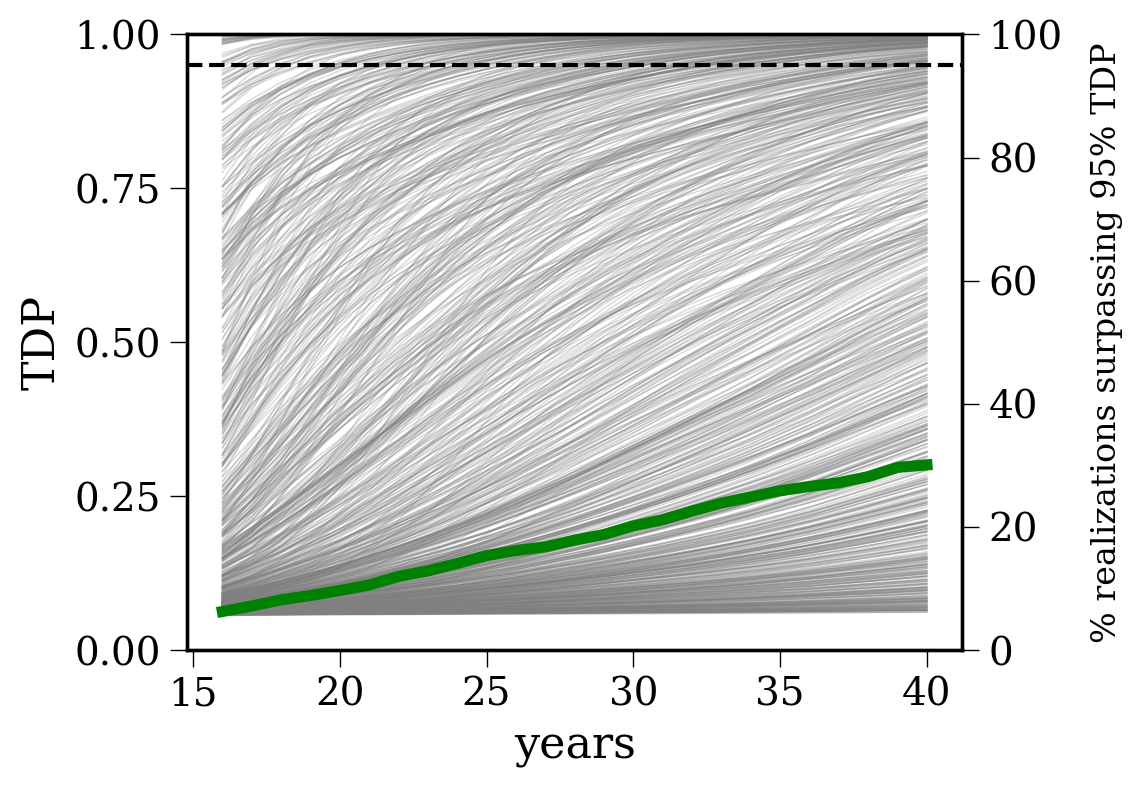

In [70]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
for realization in range(1000):
    plt.plot(yearly_years, np.array(results).T[:][realization], color = 'gray', alpha=0.3, linewidth=0.5)
plt.xlabel('years',fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0])
plt.ylabel('TDP', fontsize=16)
plt.ylim(0,1)
plt.axhline(y=0.95, linestyle='--', color = 'k', linewidth=1.5)
ax2 = ax1.twinx()
ax2.plot(yearly_years, detec, color='green', linewidth=4)
ax2.set_ylim(0,100)
plt.ylim(bottom=0)
# ax2.xaxis.label.set_color('grey')
plt.ylabel('% realizations surpassing 95% TDP', fontsize=12, labelpad=10)
#plt.savefig(f'{fig_dir}/GPTA_40yr_bg_sub_total_dp_evolution_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### can calculate the per frequency detection probability

which is $1-$ false detection probability

In [75]:
sky_maps[0].detection_prob?

Signature:
sky_maps[0].detection_prob(
    F_thresh,
    snr=None,
    Npsrs=None,
    ave=None,
    prob_kwargs={'h0': None, 'fidx': None},
)
Docstring:
Detection probability of the F-statistic
Use None for the Fe and the number of pulsars for the Fp stat.
File:      ~/src/hasasia/hasasia/skymap.py
Type:      method

In [77]:
snr_gridd = sky_maps[0].sky_ave_SNR_gridded(
        np.linspace(0, np.pi, 100),
        np.linspace(-np.pi/4, np.pi/4, 100),
        freq_bin_idxs
)

In [82]:
[sky_maps[0].detection_prob(F_thresh=8.89,
                               ave='prob',
                               prob_kwargs={'h0':h_amp_ss[0, r, 0],
                                            'fidx':0,
                                            'int_method':'trapz',
                                            'snr_grid':snr_gridd})
        for r in range(0, len(h_amp_ss[0,:, 0,]))]

[0.0014789620729278585,
 0.001492886451382236,
 0.001464418488816066,
 0.0014743508935015637,
 0.001464459297601084,
 0.0014848935077647063,
 0.0014743508935015637,
 0.0015394965676707173,
 0.001470334452522204,
 0.001492886451382236,
 0.0014654196404018105,
 0.0015218163938921503,
 0.0014665387106691519,
 0.001492886451382236,
 0.0014789620729278585,
 0.0014699179476147517,
 0.0014579141853853228,
 0.0014848935077647063,
 0.001456973053767463,
 0.001492886451382236,
 0.001492886451382236,
 0.001464459297601084,
 0.0014664455684507693,
 0.0015394965676707173,
 0.0014743508935015637,
 0.001459543952420872,
 0.001479259998853899,
 0.0015003832912505732,
 0.0014848935077647063,
 0.0014743508935015637,
 0.0014733212082793656,
 0.0014806360208587943,
 0.0014733212082793656,
 0.0015218163938921503,
 0.0014649454914734683,
 0.001492886451382236,
 0.0014789620729278585,
 0.001484753094931568,
 0.001464418488816066,
 0.001492886451382236,
 0.0017630980034919475,
 0.0015036117832394336,
 0.00147

In [79]:
snr_gridd.shape

(100, 100, 40)

In [40]:
def parallel_DP(sky_map, f, snr_grid):
    return [sky_map.detection_prob(F_thresh=8.89,
                               ave='prob',
                               prob_kwargs={'h0':h_amp_ss[f, r, 0],
                                            'fidx':f,
                                            'int_method':'trapz',
                                            'snr_grid':snr_grid})
        for r in range(0, len(h_amp_ss[0,:, 0,]))]


In [179]:
%timeit my_fdp_angle_averaged(gridded, F_thresh=8.89, h0=1e-15, fidx=freq_bin_idxs[0])

4.41 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [180]:
%timeit sky_maps[-1]._fdp_angle_averaged(F_thresh=8.89, h0=1e-15, fidx=freq_bin_idxs[0])

794 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
def parallel_DP(sky_map):
    gridded = sky_map.sky_ave_SNR_gridded(
        np.linspace(0, np.pi, 100),
        np.linspace(-np.pi/4, np.pi/4, 100),
        freq_bin_idxs
    )
    return [
        [1 - sky_map.false_dismissal_prob(
                         F_thresh=8.89,
                         ave='prob',
                         prob_kwargs={
                             'h0':h_amp_ss[fidxx, it, 0],
                             'fidx': fidxx,
                             'int_method':'trapz',
                             'snr_grid': gridded}) 
       for it in range(0, 1000)
       ]
        for fidxx in range(len(freq_bin_idxs))
        ]

In [86]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    dp = pool.map(parallel_DP, sky_maps )

In [90]:
dp = np.array(dp)
dp.shape

(25, 40, 1000)

In [286]:
yearly_years
mid = int(len(yearly_years)/2)
yearly_years[mid]

28.0

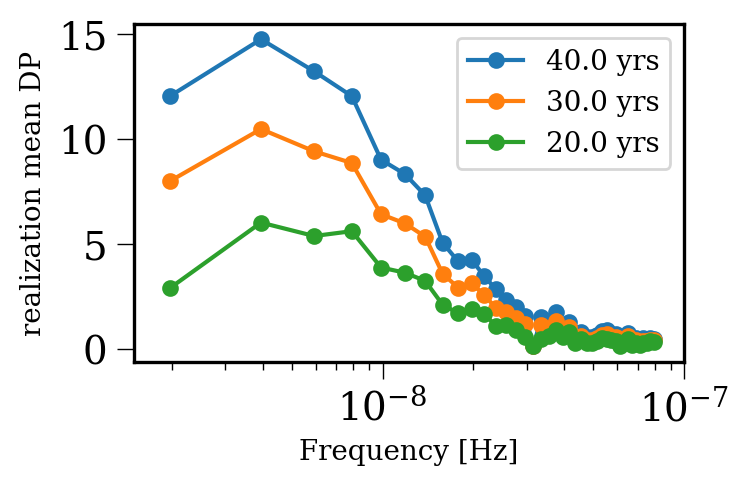

In [91]:
#average for each frequency bin
for i in [-1, 14, 4]:
    plt.semilogx(fobs, 100*np.mean(dp[i], axis=1), label = f"{yearly_years[i]} yrs", marker=".", markersize=10)
    # plt.fill_between(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.68, axis=1), 
    #                        np.quantile(sky_ave_per_freq_dp[i], q=0.32, axis=1), alpha=0.5)
plt.legend(loc=1, fontsize=10)
plt.xlim(1.5e-9, 1e-7)
plt.xlabel("Frequency [Hz]")
plt.ylabel("realization mean DP")
#plt.savefig(f'{fig_dir}/GPTA_40yr_per_freq_mean_dp_evolution.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

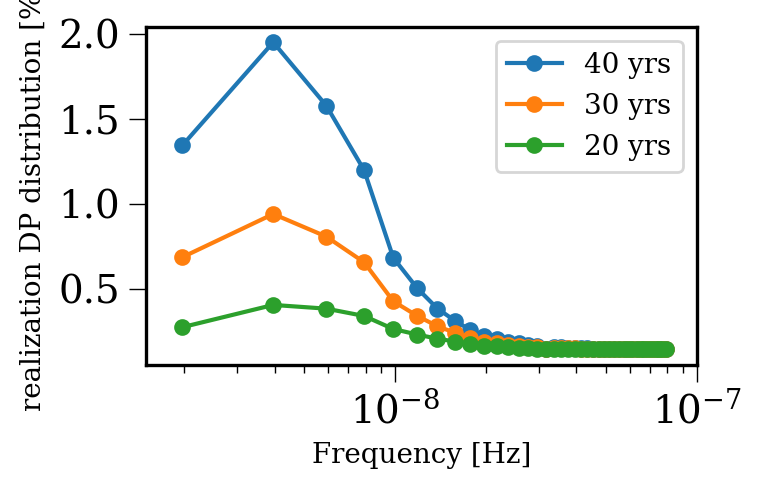

In [92]:
#average for each frequency bin
for i in [-1, 14, 4]:
    plt.semilogx(fobs, 100*np.median(dp[i], axis=1), label = f"{yearly_years[i]:.0f} yrs", marker=".", markersize=10)
    #plt.fill_between(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.84, axis=1), 
    #                       np.quantile(sky_ave_per_freq_dp[i], q=0.16, axis=1), alpha=0.5)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.68, axis=1), linewidth=0.5, alpha=0.5)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.32, axis=1), linewidth=0.5, alpha=0.5)
plt.legend(loc=1, fontsize=10)
plt.xlim(1.5e-9, 1e-7)
plt.xlabel("Frequency [Hz]")
plt.ylabel("realization DP distribution [%]")
#plt.savefig(f'{fig_dir}/GPTA_40yr_per_freq_median_dp_evolution.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

### the above doesnt make sense because it is always the outliers that get detected

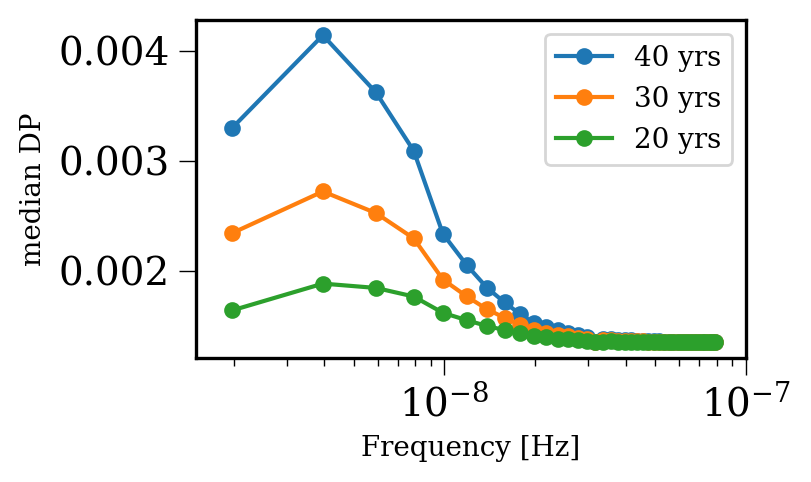

In [63]:
#average for each frequency bin
for i in [-1, 14, 4]:
    plt.semilogx(fobs, np.median(sky_ave_per_freq_dp[i], axis=1), 
                 label = f"{yearly_years[i]:.0f} yrs", marker=".", markersize=10)
    # plt.fill_between(fobs, 100*np.quantile((np.median(sky_ave_per_freq_dp[i], axis=1)-np.median(sky_ave_per_freq_dp[0], axis=1))/np.median(sky_ave_per_freq_dp[0], axis=1), q=0.68, axis=0), 
    #                         100*np.quantile((np.median(sky_ave_per_freq_dp[i], axis=1)-np.median(sky_ave_per_freq_dp[0], axis=1))/np.median(sky_ave_per_freq_dp[0], axis=1), q=0.32),
    #                         alpha=0.3)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.68, axis=1), linewidth=0.5, alpha=0.5)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.32, axis=1), linewidth=0.5, alpha=0.5)
plt.legend(loc=1, fontsize=10)
plt.xlim(1.5e-9, 1e-7)
plt.xlabel("Frequency [Hz]")
plt.ylabel("median DP", fontsize=10)
plt.show()

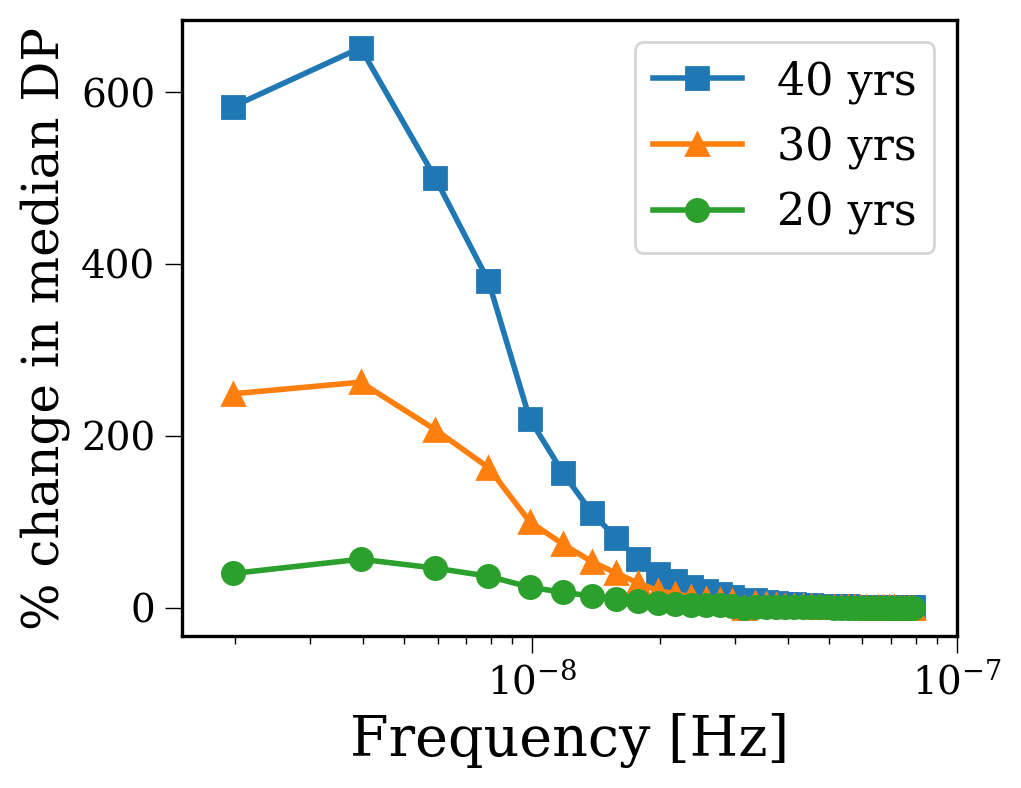

In [ ]:
#average for each frequency bin
markers = ['s','^','o']
fig = plt.figure(figsize=(5,4))
for ii, i in enumerate([-1, 14, 4]):
    plt.semilogx(fobs, 100.*(np.median(dp[i], axis=1)-np.median(dp[0], axis=1))/np.median(dp[0], axis=1), 
                 label = f"{yearly_years[i]:.0f} yrs", marker=markers[ii],markersize=8, linewidth=2)
    # plt.fill_between(fobs, 100*np.quantile((np.median(sky_ave_per_freq_dp[i], axis=1)-np.median(sky_ave_per_freq_dp[0], axis=1))/np.median(sky_ave_per_freq_dp[0], axis=1), q=0.68, axis=0), 
    #                         100*np.quantile((np.median(sky_ave_per_freq_dp[i], axis=1)-np.median(sky_ave_per_freq_dp[0], axis=1))/np.median(sky_ave_per_freq_dp[0], axis=1), q=0.32),
    #                         alpha=0.3)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.68, axis=1), linewidth=0.5, alpha=0.5)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.32, axis=1), linewidth=0.5, alpha=0.5)
plt.legend(loc=1, fontsize=16)
plt.xlim(1.5e-9, 1e-7)
plt.xlabel("Frequency [Hz]", fontsize=20)
plt.ylabel("% change in median DP", fontsize=18)
#plt.savefig(f'{fig_dir}/GPTA_40yr_per_freq_median_dp_evolution_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

<Figure size 500x400 with 0 Axes>

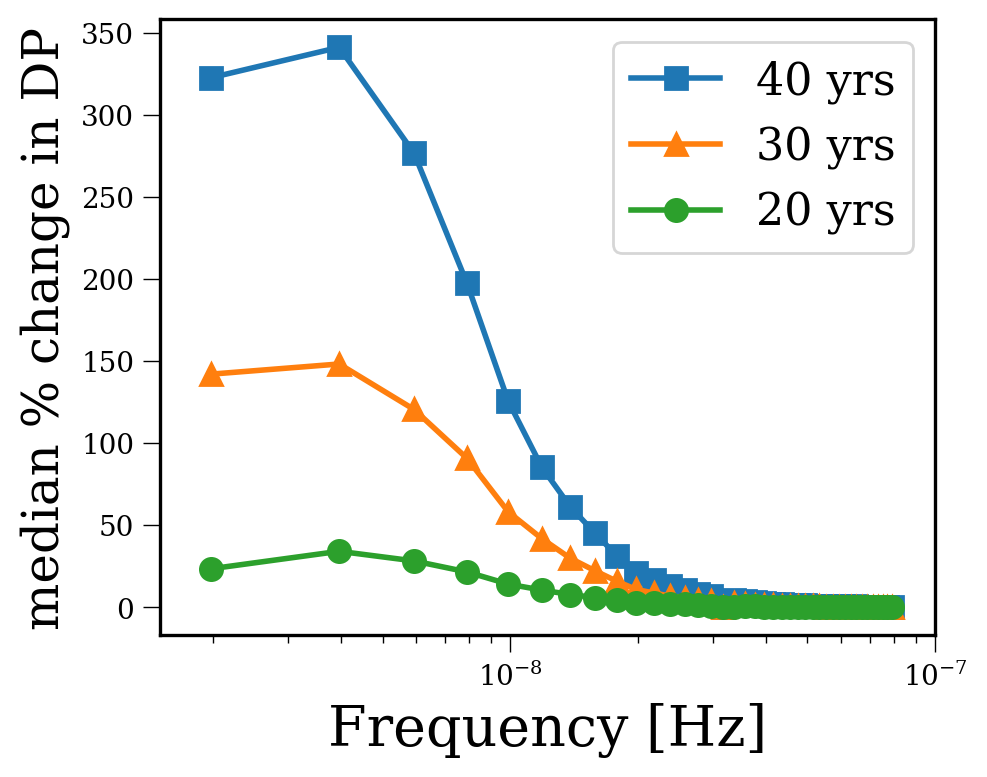

In [292]:
#average for each frequency bin
markers = ['s','^','o']
fig = plt.figure(figsize=(5,4))
for ii, i in enumerate([-1, 14, 4]):
    quantity = 100*((np.array(dp[i]) - np.array(dp[0]))/np.array(dp[0]))
    plt.semilogx(fobs, np.median(quantity, axis=1),
                 label = f"{yearly_years[i]:.0f} yrs", marker=markers[ii],markersize=8, linewidth=2)
    # plt.fill_between(fobs, np.quantile(quantity, q=0.84, axis=1), 
    #                         np.quantile(quantity, axis=1, q=0.32),
    #                         alpha=0.3)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.68, axis=1), linewidth=0.5, alpha=0.5)
    # plt.semilogx(fobs, np.quantile(sky_ave_per_freq_dp[i], q=0.32, axis=1), linewidth=0.5, alpha=0.5)
plt.legend(loc=1, fontsize=16)
plt.xlim(1.5e-9, 1e-7)
plt.xlabel("Frequency [Hz]", fontsize=20)
plt.ylabel("median % change in DP", fontsize=18)
#plt.savefig(f'{fig_dir}/GPTA_40yr_per_freq_dp_median_evolution_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [48]:
# sources
#mass in Msun, D_L in Mpc, f(_GW?) in Hz
s1 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=7e-10).to('')
s2 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=4e-9).to('')
s3 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=1.15e-8).to('')
s4 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=2.8e-8).to('')
s5 = hsky.h0_circ(M_c=10e9, D_L=10**3.2, f0=8e-8).to('')
source_h0s = [s1.value, s2.value, s3.value, s4.value, s5.value]
#h0_freqs = [7e-10, 4e-9, 1.15e-8, 2.8e-8] 
# swapping to the below since they fit our curve better?
h0_freqs = [2e-9, 5e-9, 2e-8, 4e-8, 8e-8]
source_freqs = [np.argmin(abs(freqs-h0_freqs[i])) for i in range(len(h0_freqs))]
source_h0s

[2.7443824468119924e-15,
 8.77174370311675e-15,
 1.7735543416856256e-14,
 3.2098491819673166e-14,
 6.463076020056513e-14]

# 4) Consider Det Stats on an alt. campaign

In [42]:
hpsrs = reset_psrs_fullAmp()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


PTA spectrum with 133 psrs created.


In [43]:
start_year = 20
hpsrs = reset_psrs_fullAmp()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [44]:
# create modified campaign
hpsrs = reset_psrs_fullAmp()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.01
cadence_factor = 4
thin_cadence_factor = 1/2
pulsars_dropped_per_year = 6
iterations = 10

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [45]:
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)

119

In [49]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = reset_psrs_fullAmp()
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(idx_best_to_worst_filtered[:iterations]): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
    for idx in range(pulsars_dropped_per_year):
        print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[idx_sorted_filtered[i*pulsars_dropped_per_year+idx]].name)
        hpsrs[idx_sorted_filtered[pulsars_dropped_per_year*i+idx]].change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    # create psr spectra at end of cadence
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J1015+0331
old: 791, new: 690
1:4) reducing pulsar  J0326+0145
old: 792, new: 692
1:5) reducing pulsar  J2154-0231
old: 691, new: 591
1:6) reducing pulsar  J1535-0011
old: 662, new: 561
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1135+0251
old: 684, new: 584
2:2) reducing pulsar  J2100-0048
old: 557, new: 457
2:3) reducing pulsar  J2052+0211
old: 550, new: 450
2:4) reducing pulsar  J1514-0303
old: 646, new: 546
2:5) reducing pulsar  J0122-0052
old: 566, new: 466
2:6) reducing pulsar  J2028-0020
old: 789, new: 689
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
PTA spectrum with 133 psrs created.
3:1) reducing pulsar  J1726+0347
old: 658, new: 558
3:2) reducing puls

In [50]:
legs = [mpl.lines.Line2D([0], [0], color='grey', markeredgecolor=None, linestyle='', marker='.', markersize=12, 
                         label = r'Realization loudest'+'\n'+r" $\rm f_{\rm GW}$ bin source"),
        mpl.lines.Line2D([0], [0], color='k', markeredgecolor='k', linestyle='--', marker='', label = 'injected GWB'),
        ]

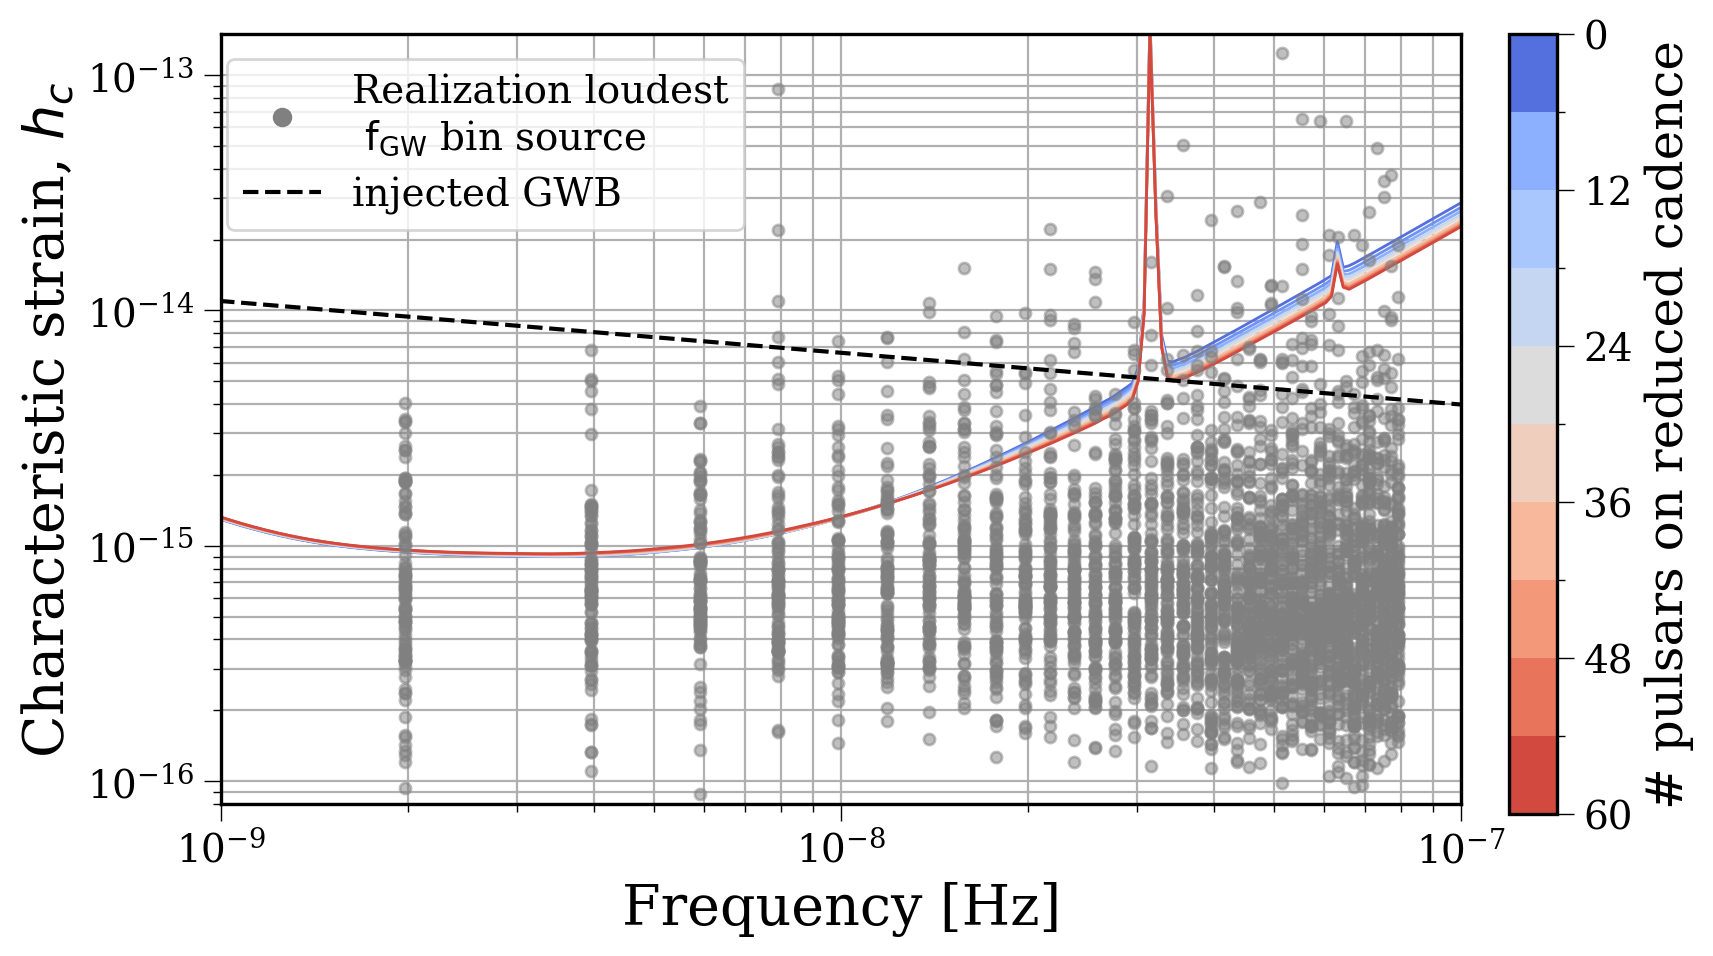

In [51]:
# Plot skymap SC
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=iterations+1)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
fig = plt.figure(figsize=[8,5])
for rr in range(1000)[::10]:
    if(rr==0):
        label_bg = 'Realization GWB'
        label_ss = r'Realization loudest $\rm f_{gw}$ bin source'
    else:
        label_bg = None
        label_ss = None
    #plt.scatter(fobs, hc_ss[:,rr,0], alpha=0.5, label=label_ss, color='teal')#color=colors[rr])
    plt.scatter(fobs, c_i[:,rr]*hc_ss[:,rr,0], alpha=0.5, label=label_ss, color='gray', zorder=3)#color=colors[rr]) 
for i, sc in enumerate(SMs):
    linewidth=1
    ## changing this to 4 for now jeremy 12/8
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1)
plt.loglog(freqs, inj_gwb_hc, color='k', linestyle='--', label='injected GWB', zorder=5 )
plt.legend(handles=legs, loc=(0.005, .745), fontsize=14,)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain, $h_{c}$', fontsize=20)
plt.grid(which='both')
plt.xlim((1e-9, 1e-7))
plt.ylim((.8e-16, 1.5e-13))
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(pulsars_dropped_per_year*np.flip(range(iterations+1)), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=pulsars_dropped_per_year*np.flip(range(iterations+1)),ticklocation='right')
ax2.set_ylabel('# pulsars on reduced cadence', fontsize=18)
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_sc_realizations_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [52]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    opt_camp_tdp = np.array(pool.map(parallel_TDP, SMs))
opt_camp_tdp.shape

/home/baierj/anaconda3/envs/hasasia2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(11, 1000)

In [ ]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    opt_camp_dp = np.array(pool.map(parallel_DP, SMs))
opt_camp_dp.shape

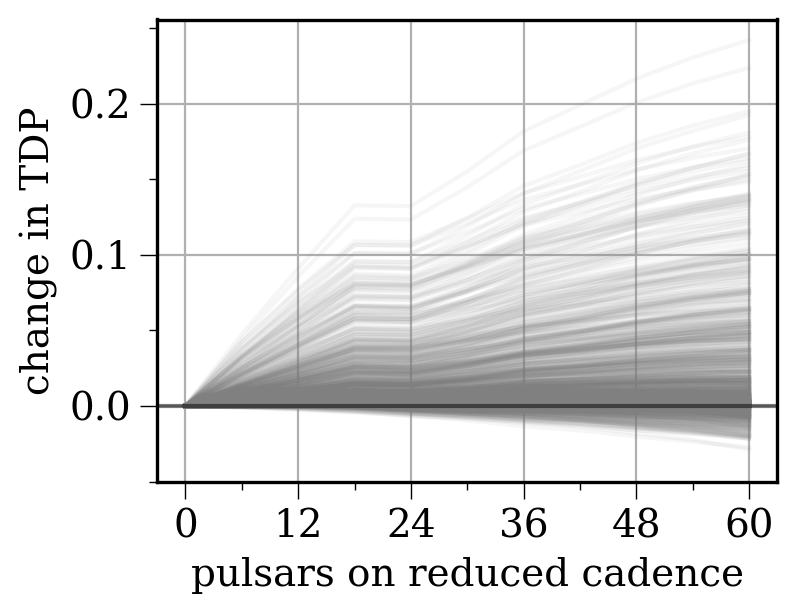

In [57]:
plt.figure(figsize=(4,3))
plt.gca().grid()
for r in range(1000):
    plt.plot(6*np.arange(0, 11), (opt_camp_tdp[:, r] - opt_camp_tdp[0,r]), color='grey', alpha=0.07)
plt.axhline(0, color='k', linestyle='-', alpha=0.5)
plt.yticks([-.05, 0., .05, .10, .15, .20, .25], minor=True)
plt.yticks([0, .10, .20])
plt.xticks([0, 12, 24, 36, 48, 60])
plt.xticks(6*np.arange(0,11), minor=True)
plt.xlabel('pulsars on reduced cadence', fontsize=14)
plt.ylabel('change in TDP', fontsize=14)
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_change_TDP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

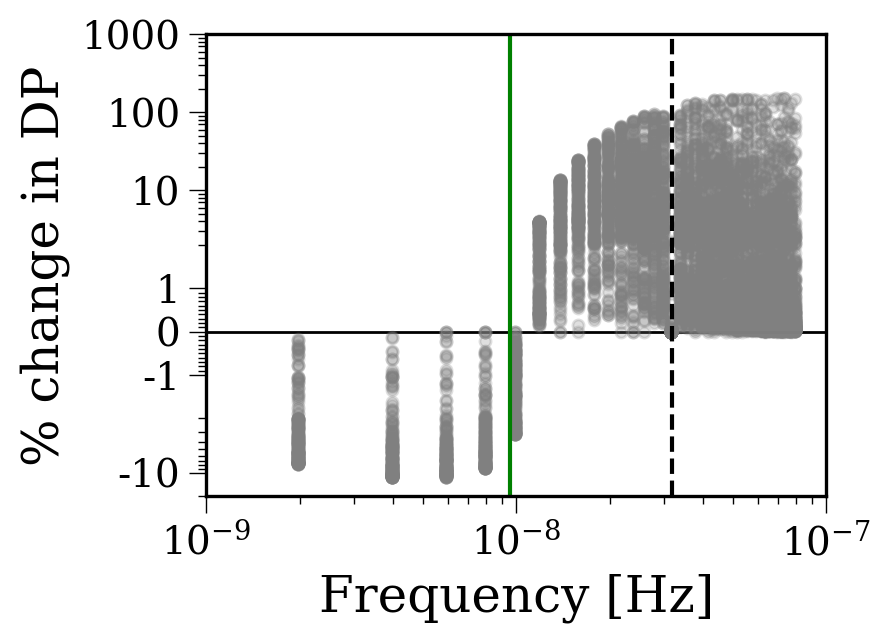

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, zorder=1)
for i in range(1000)[::5]:
    plt.scatter(fobs,100*(opt_camp_dp[-1,:,i]-opt_camp_dp[0, :, i])/opt_camp_dp[0, :, i], color='grey', alpha=0.25)
ytix = np.concatenate([[-20],-1*np.linspace(0,1,11), -1*np.linspace(0,10,11), 1*np.linspace(0,1,11), np.linspace(1,10,10), np.linspace(10,100,10), np.linspace(100,1000,10)])
plt.xlim(1e-9,1e-7)
plt.axvline(1/(365.25*3600*24), color='k', linestyle='--')
plt.axvline(3/(10*365.25*24*3600), color='green')
plt.axhline(0, color='k', linewidth=1, zorder=0)
ax.set_xscale('log')
ax.set_yscale('symlog')
plt.yticks([-10,-1,0,1,10,100,1000],[-10,-1,0,1,10,100,1000])
plt.yticks(ytix,minor=True )
plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('% change in DP', fontsize=18)
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_change_per_freq_DP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

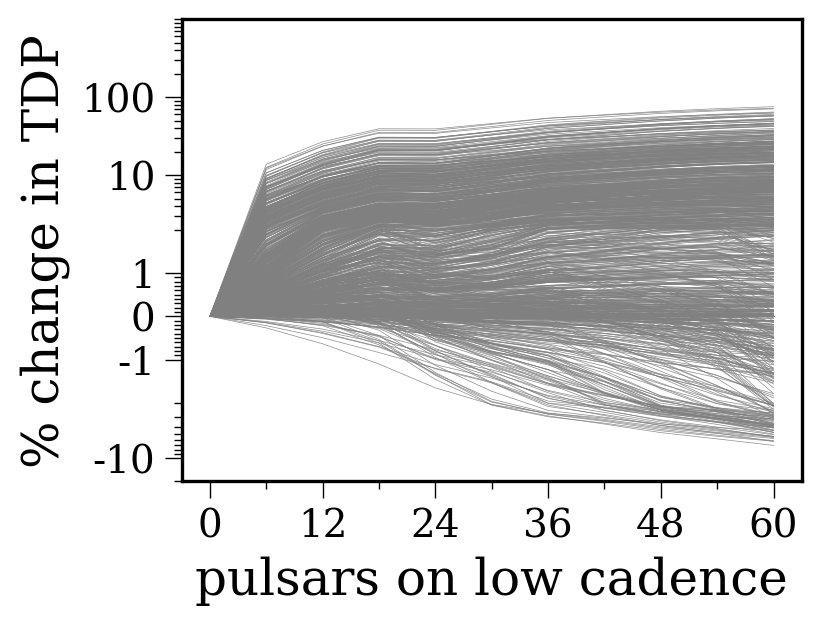

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, zorder=1)
xtix = np.rint(6*(np.linspace(1,11,11)-1))
ytix = np.concatenate([[-20],-1*np.linspace(0,1,11), -1*np.linspace(0,10,11), 1*np.linspace(0,1,11), np.linspace(1,10,10), np.linspace(10,100,10), np.linspace(100,1000,10)])
for realization in range(1000):
    plt.plot(6*(np.linspace(1,11,11)-1), 100*((np.array(opt_camp_tdp)[:, realization]-np.array(opt_camp_tdp)[0, realization])/np.array(opt_camp_tdp)[0, realization]),
             alpha=0.9, color='grey', linewidth=0.25)
ax.set_yscale('symlog')
plt.xlabel('pulsars on low cadence', fontsize=18, )
plt.ylabel('% change in TDP', fontsize=18)
plt.yticks([-10,-1,0,1,10,100],[-10,-1,0,1,10,100])
plt.yticks(ytix,minor=True )
plt.xticks(xtix, minor=True)
plt.xticks([0,12, 24, 36, 48, 60])
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_change_TDP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

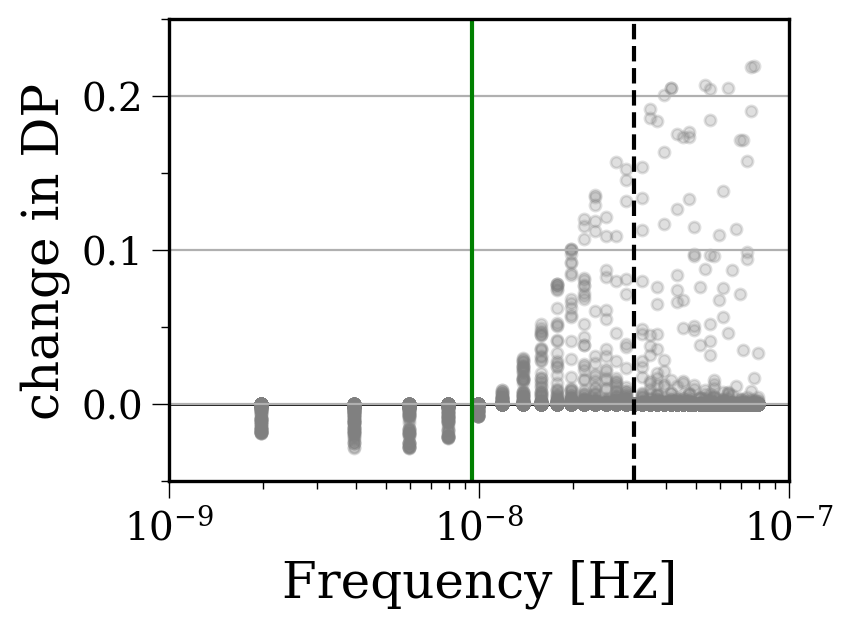

In [163]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, zorder=1)
plt.grid(axis='y', alpha=1)
for i in range(1000)[::5]:
    plt.scatter(fobs,(opt_camp_dp[-1,:,i]-opt_camp_dp[0, :, i]), color='grey', alpha=0.25)
plt.xlim(1e-9,1e-7)
plt.axvline(1/(365.25*3600*24), color='k', linestyle='--')
plt.axvline(3/(10*365.25*24*3600), color='green')
plt.axhline(0, color='k', linewidth=1, zorder=0)
ax.set_xscale('log')
plt.yticks([0,.10, .20])
plt.yticks([-.05, 0, .05, .10, .15, .20, .25],minor=True )
plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('change in DP', fontsize=18)
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_change_per_freq_DP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [91]:
#this line gets the SM index of the data set frequency bins (this is the same for all realizations)
freq_indcs = np.array([np.argmin(abs(freqs-fobs[ii])) for ii in range(len(fobs))])
# gets the indices of the best and worst sky position (at the first frequency)
# idx_of_worst_sky_position = np.argmax(SMs[0].S_effSky[0])
# idx_of_best_sky_position = np.argmin(SMs[0].S_effSky[0])

# this calculates the snr at two specific sky locations across all frequency bins for all the realizations
# note that the factor of 2 difference is included here !!!!! don't double count it elsewhere.
freq_bin_idxs = [np.argmin(abs(fobs[indx]-freqs)) for indx in range(len(fobs))]
# best_sky_loc_snr=0.5*np.array([[SMs[0].SNR(h_amp_ss[inx,realization,0])[freq_bin_idxs[inx],idx_of_best_sky_position] for inx in range(len(fobs))] for realization in range(len(h_amp_ss[0]))]).T
# worst_sky_loc_snr=0.5*np.array([[SMs[0].SNR(h_amp_ss[inx,realization,0])[freq_bin_idxs[inx],idx_of_worst_sky_position] for inx in range(len(fobs))] for realization in range(len(h_amp_ss[0]))]).T


## and add Next Gen Telescope in the mix

In [38]:
hpsrs = reset_psrs_fullAmp()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.


In [39]:
start_year = 20
hpsrs = reset_psrs_fullAmp()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]
idx_best_to_worst_filtered = []

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [40]:
# create modified campaign
#hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.01
cadence_factor = 5
thin_cadence_factor = 2/3
pulsars_dropped_per_year = 0
#pulsars_dropped_per_year = (cadence_factor-1)/(1-thin_cadence_factor)
iterations = 24
sigma_factor = 1/10.
pulsars_dropped_per_year

0

In [41]:
pulsars_dropped_per_year = int(pulsars_dropped_per_year)
np.intersect1d(idx_best_to_worst_filtered[:iterations], idx_sorted_filtered[:iterations*pulsars_dropped_per_year])

array([], dtype=float64)

In [42]:
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)

119

In [43]:
def reset_psrs_to_perf_sub():
    return sim_pta_w_inj_gwb(A_gwb = 10**A_gwb/2, alpha_gwb = alpha_gwb)

In [44]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = reset_psrs_fullAmp() #reset_psrs_to_perf_sub()
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(idx_best_to_worst_filtered[:iterations]): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
#     for idx in range(pulsars_dropped_per_year):
#         print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[idx_sorted_filtered[i*pulsars_dropped_per_year+idx]].name)
#         hpsrs[idx_sorted_filtered[pulsars_dropped_per_year*i+idx]].change_cadence(
#                 start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
#                 cadence=None, cadence_factor=thin_cadence_factor, uneven=False,
#                 A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_sigma(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        sigma_factor=sigma_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    # create psr spectra at end of cadence
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.


NameError: name 'source_h0s' is not defined

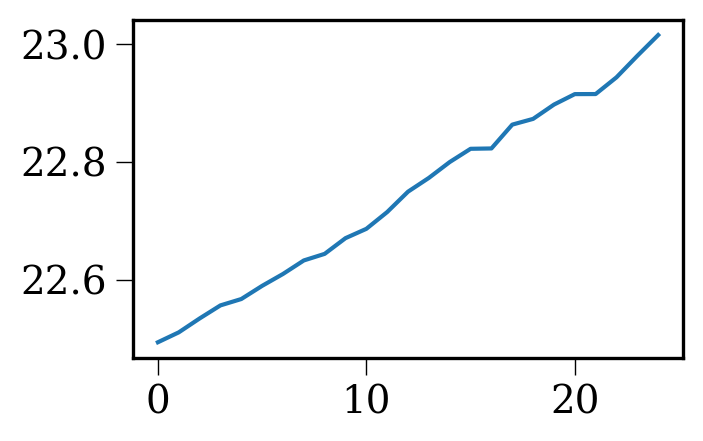

In [ ]:
plt.plot(np.linspace(0,iterations,iterations+1), GWBSNRs)
plt.show()

In [ ]:
legs = [mpl.lines.Line2D([0], [0], color='grey', markeredgecolor=None, linestyle='', marker='.', markersize=12, 
                         label = 'Realization loudest\n'+' '+r"$\rm f_{\rm GW}$ bin source"),
        mpl.lines.Line2D([0], [0], color='k', markeredgecolor='k', linestyle='--', marker='', label = 'injected GWB'),
        #mpl.lines.Line2D([0], [0], color='k', markeredgecolor='k', linestyle='-.', marker='', label = 'strain noise in GWB earth term')
        ]


In [ ]:
np.arange(25)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

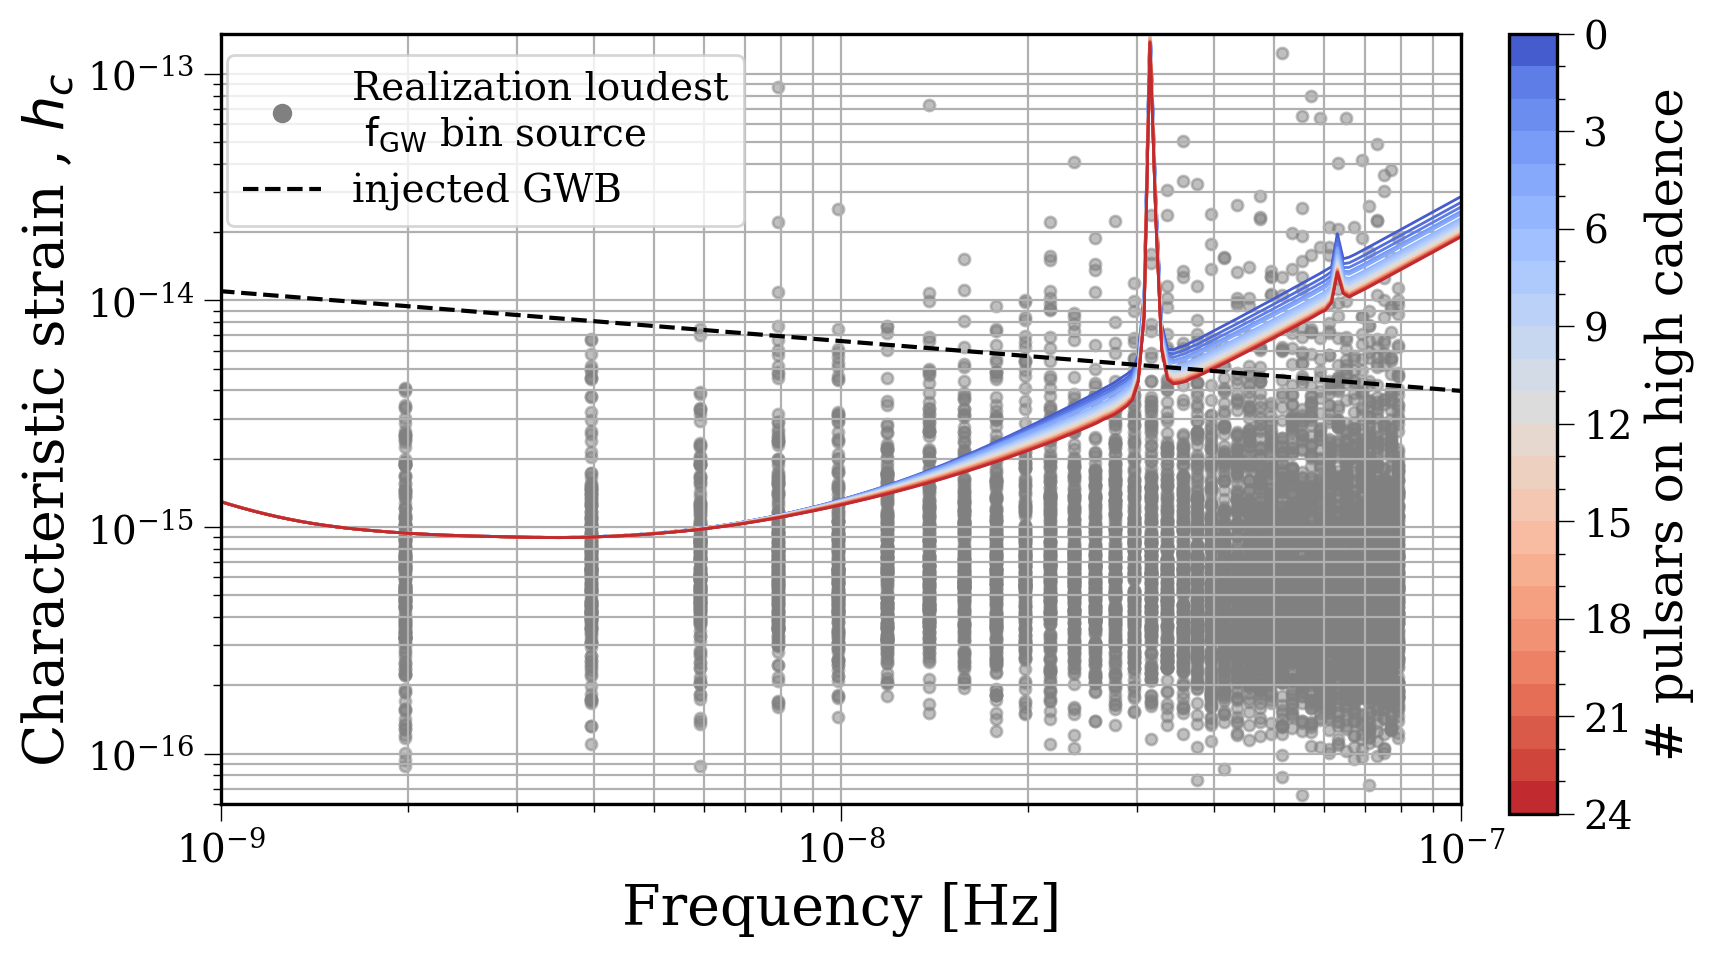

In [ ]:
# Plot skymap SC
# color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs)))
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=iterations+1)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
fig = plt.figure(figsize=[8,5])
for rr in range(1000)[::5]:
    if(rr==0):
        label_bg = 'Realization GWB'
        label_ss = r'Realization loudest $\rmf_{\rm GW}$\nbin source'
    else:
        label_bg = None
        label_ss = None
    # plt.loglog(fobs, hc_bg[:,rr], alpha=0.5, label=label_bg, color="grey")#color=colors[rr])
    # plt.scatter(fobs, hc_ss[:,rr,0], alpha=0.5, label=label_ss, color='teal')#color=colors[rr])
    plt.scatter(fobs, c_i[:,rr]*hc_ss[:,rr,0], alpha=0.5, label=label_ss, color='gray')#color=colors[rr]) 
for i, sc in enumerate(SMs):
    linewidth=1
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1)
#plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain , $h_{c}$', fontsize=20)
plt.loglog(freqs, inj_gwb_hc, color='k', linestyle='--', label='injected GWB', zorder=5 )
#plt.loglog(freqs, inj_gwb_hc/2, color='k', linestyle='-.', label='strain noise in GWB earth-term', zorder=5 )
plt.legend(handles=legs, loc=(0.005, 0.75), fontsize=14,)
#plt.title(f'Sky-Aved. alt campaign @{end_year:.1f}yrs', fontsize = 24)
plt.grid(which='both')
plt.xlim((1e-9, 1e-7))
plt.ylim((.6e-16, 1.5e-13))
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(1*np.flip(range(iterations+1)), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=range(iterations+1),ticklocation='right',)
ax2.set_ylabel('# pulsars on high cadence', fontsize=18)
#ax2.set_yticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
#ax2.set_yticklabels([0,2,4,6,8,10,12,14,16,18,20,22,24])
#plt.savefig(f'{fig_dir}/MT_treatment_wo_bg_sub_scs_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

### do detector volume

In [45]:
def strain_and_chirp_mass_to_luminosity_distance(h, M_c, f0):
    return (2*hsky.c.c / (h * hsky.u.m/hsky.u.m)
            * np.power(hsky.c.G * M_c * hsky.u.Msun/hsky.c.c**3, 5/3)
            * np.power(np.pi * f0 * hsky.u.Hz, 2/3)).to('Mpc')

def calculate_detection_volume(skymap, frequency, SNR_threshold, M_c):
    """
    Calculates the detection volume of your PTA
    at a given frequency or list of frequencies.

    Parameters
    ==========
    skymap - hasasia.skymap
        the hasasia.skymap to use
    frequency - float
        the frequency [Hz] at which to calculate detection volume
    SNR_threshold - float
        the signal to noise to referene detection volume to
    M_c - float
        the chirp mass [Msun] at which to reference detection volume
    Returns
    =======
    volume - float
        the detection volume in Mpc^3
    """
    NSIDE = hp.pixelfunc.npix2nside(skymap.S_eff.shape[1])
    dA = hp.pixelfunc.nside2pixarea(NSIDE, degrees=False)
    if isinstance(frequency, (int,float)):
        f_idx = np.array([np.argmin(abs(skymap.freqs - frequency))])
    elif isinstance(frequency, (np.ndarray, list)):
        f_idx = np.array([np.argmin(abs(skymap.freqs - f)) for f in frequency])
    h0 = skymap.h_thresh(SNR=SNR_threshold)
    volume = [dA*1/3.*np.sum(
        strain_and_chirp_mass_to_luminosity_distance(h0[fdx], M_c, skymap.freqs[fdx])**3,
        axis=0).value for fdx in f_idx]
    return volume[0] if len(volume)==1 else volume

In [46]:
SNRs = []
for i in range(len(GWBSNRs)):
    SNRs.append([np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s)-1)])
src_snr = np.array(SNRs).T
snr_3sig = 3.7145
detvol1 = np.array([calculate_detection_volume(SM,SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=1e9) for _, SM in enumerate(SMs)]).T

NameError: name 'source_h0s' is not defined

In [226]:
detvol1.shape

(5, 25)

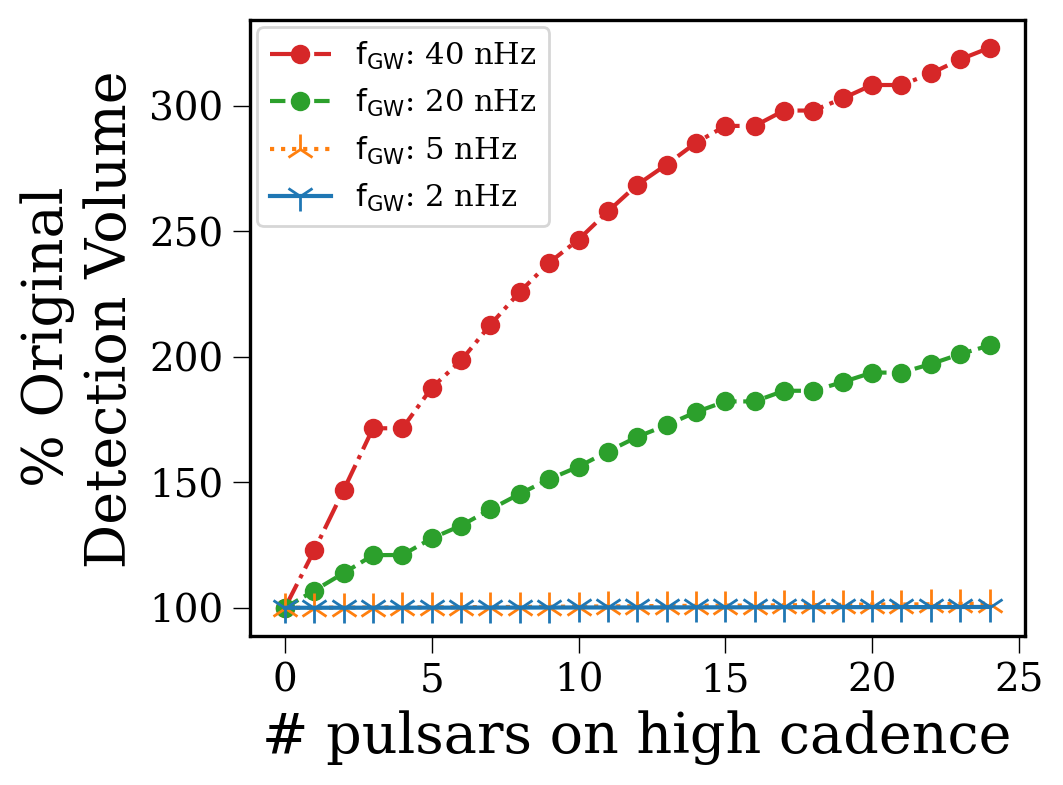

In [ ]:
dropped = np.arange(iterations+1)
fig = plt.figure(figsize=(5,4))
det_vol = detvol1
linestyles=['solid', 'dotted', 'dashed', 'dashdot']
markerss=['1','2','o','o']
sizess = [11,11,6,6]
for i in np.flip(range(4)):
    plt.plot(dropped, 100*det_vol[i]/det_vol[i][0], 
             marker=markerss[i], color=f"C{i}", linestyle=linestyles[i], markersize=sizess[i],
             label=r"$\rm f_{\rm GW}$:"+f" {freqs[source_freqs[i]]/1e-9:.0f} nHz")
plt.xlabel("# pulsars on high cadence", fontsize=20)
plt.ylabel("% Original \n Detection Volume", fontsize=20)
plt.legend(loc=(0.01,0.665), fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig(f'{fig_dir}/MT_treatment_wo_bg_sub_change_DV_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

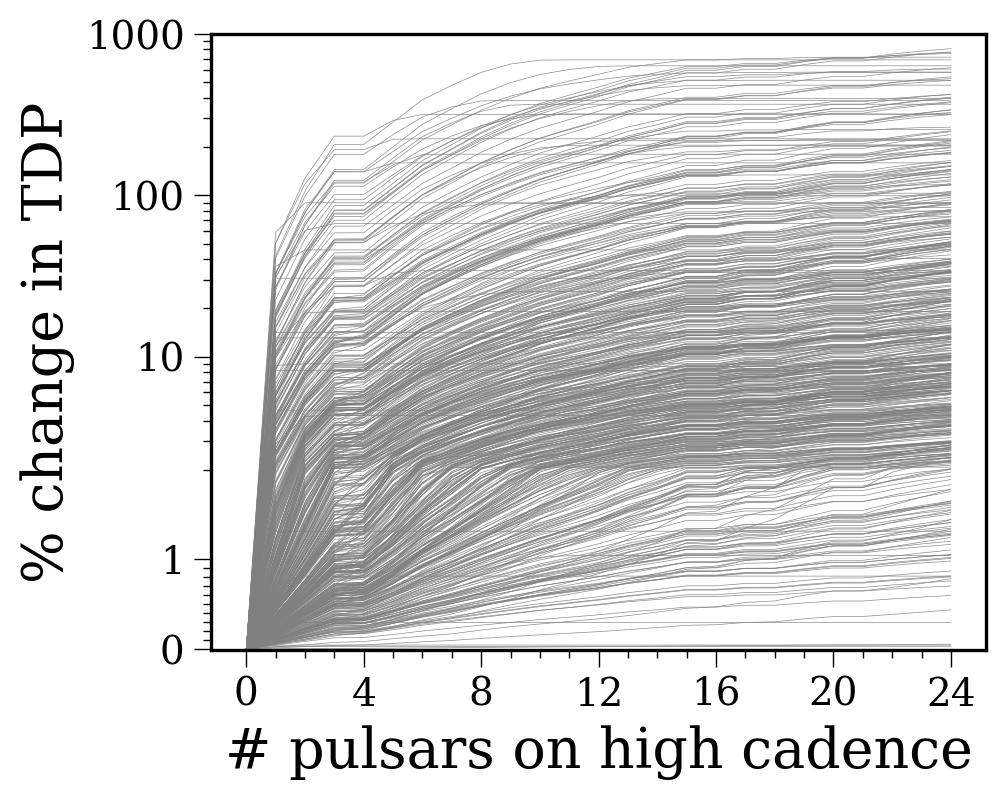

In [261]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ytix = np.concatenate([1*np.linspace(0,1,11), np.linspace(1,10,10), np.linspace(10,100,10), np.linspace(100,1000,10)])
for realization in range(1000):
    plt.plot((np.linspace(0,iterations, iterations+1)), 100*(np.array(agg_sky_ave).T[realization]-np.array(agg_sky_ave).T[realization][0])/np.array(agg_sky_ave).T[realization][0],
             alpha=0.9, color='grey', linewidth=0.25)
ax.set_yscale('symlog')
plt.xlabel('# pulsars on high cadence', fontsize=20, )
plt.ylabel('% change in TDP', fontsize=20)
plt.yticks(ytix,minor=True)
plt.yticks([0,1,10,100,1000], [0,1,10,100,1000])
plt.xticks(np.arange(iterations+1), minor=True)
plt.xticks(np.arange(0,25,4))
#plt.xlim(0,12)
plt.ylim(-0.01,1000)
#plt.savefig(f'{fig_dir}/MT_treatment_wo_bg_sub_change_TDP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

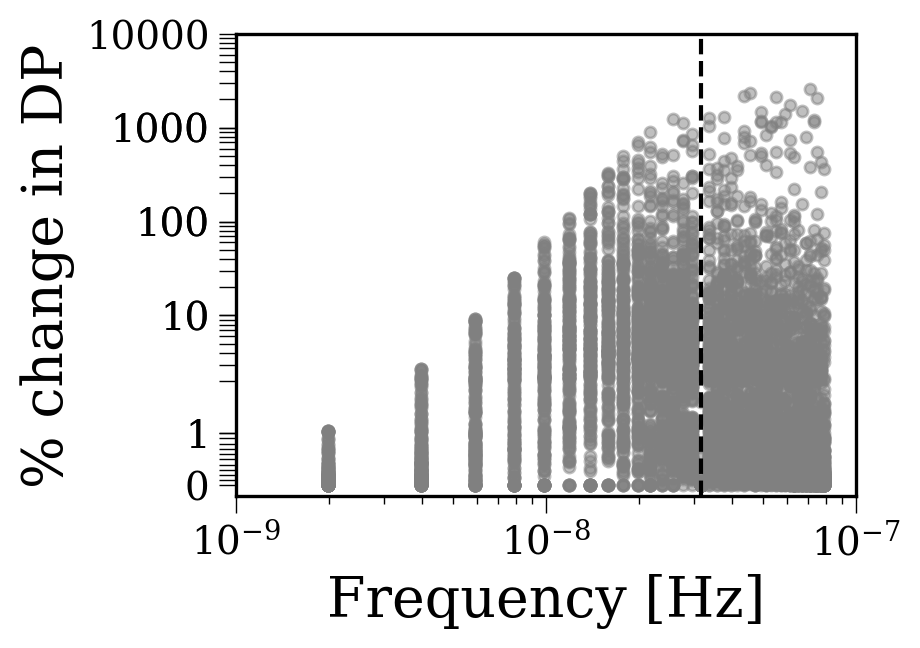

In [67]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, zorder=1)
ytix = np.concatenate([np.linspace(0,1,11), np.linspace(1,10,10), np.linspace(10,100,10), np.linspace(100,1000,10), np.linspace(1000,10000,10)])
for i in range(1000)[::5]:
    plt.scatter(fobs,100*(pfdp[-1][i]-pfdp[0][i])/pfdp[0][i], color='grey', alpha=0.5)
#plt.grid(which='both',zorder=-100)
plt.ylim(bottom=-0.2, top = 10000)
plt.xlim(1e-9,1e-7)
plt.axvline(1/(365.25*3600*24), color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('symlog')
ax.set_yticks([0,1,10,100,1000,10000], [0,1,10,100,1000,10000])
ax.set_yticks(ytix)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('% change in DP', fontsize=20)
#plt.savefig(f'{fig_dir}/MT_treatment_wo_bg_sub_change_DP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [229]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    opt_camp_tdp = np.array(pool.map(parallel_TDP, SMs))
opt_camp_tdp.shape


/home/baierj/anaconda3/envs/hasasia2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/baierj/anaconda3/envs/hasasia2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(25, 1000)

In [230]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    opt_camp_dp = np.array(pool.map(parallel_DP, SMs))
opt_camp_dp.shape


(25, 40, 1000)

In [ ]:
np.concatenate(np.arange(0, 25,3))

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24,  0])

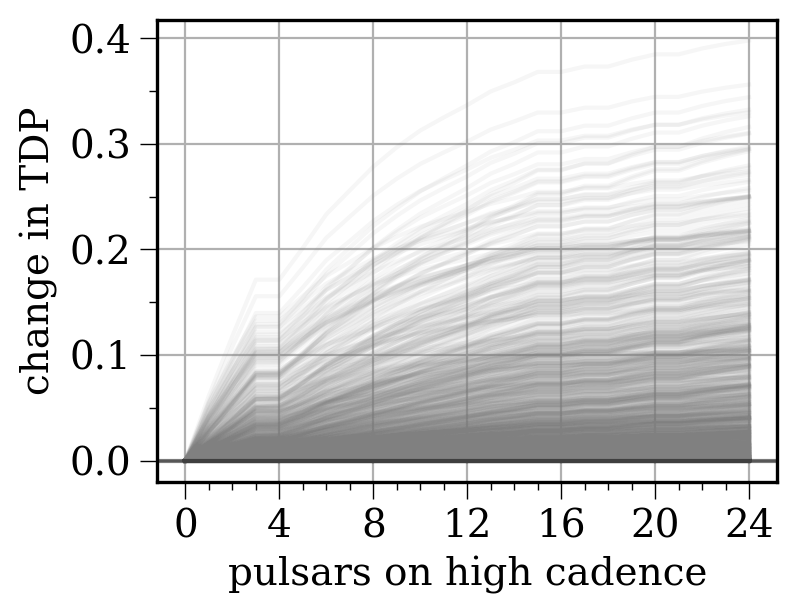

In [258]:
plt.figure(figsize=(4,3))
plt.gca().grid()
for r in range(1000):
    plt.plot(np.arange(0, 25), (opt_camp_tdp[:, r] - opt_camp_tdp[0,r]), color='grey', alpha=0.07)
plt.axhline(0, color='k', linestyle='-', alpha=0.5)
plt.yticks(0.01*np.array([0, 5, 10, 15, 20, 25, 35]), minor=True)
plt.yticks(0.01*np.array([0, 10, 20, 30, 40]))
plt.xticks(np.arange(0, 25, 4))
plt.xticks(np.arange(0,25), minor=True)
plt.xlabel('pulsars on high cadence', fontsize=14)
plt.ylabel('change in TDP', fontsize=14)
#plt.savefig(f'{fig_dir}/MT_treatment_wo_bg_sub_change_TDP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

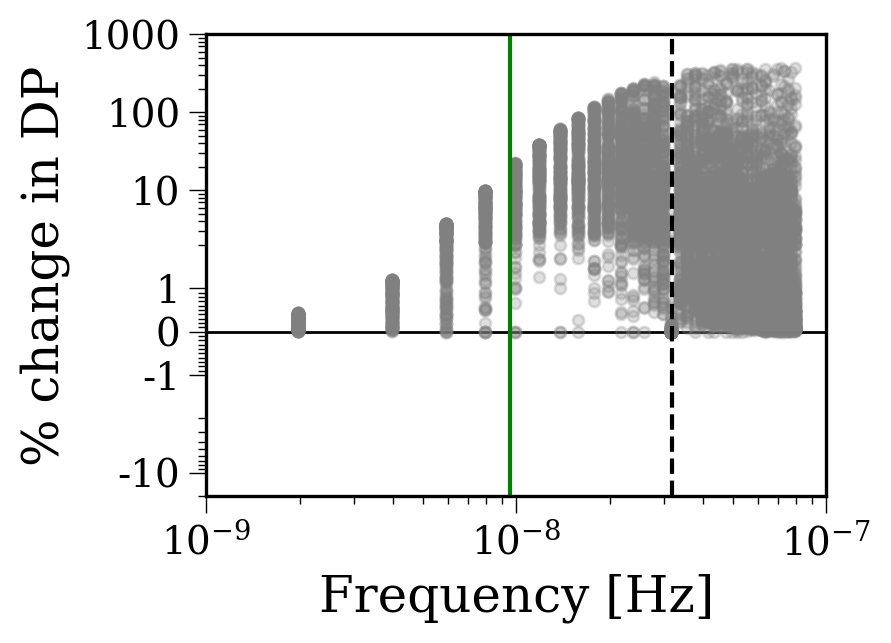

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, zorder=1)
for i in range(1000)[::5]:
    plt.scatter(fobs,100*(opt_camp_dp[-1,:,i]-opt_camp_dp[0, :, i])/opt_camp_dp[0, :, i], color='grey', alpha=0.25)
ytix = np.concatenate([[-20],-1*np.linspace(0,1,11), -1*np.linspace(0,10,11), 1*np.linspace(0,1,11), np.linspace(1,10,10), np.linspace(10,100,10), np.linspace(100,1000,10)])
plt.xlim(1e-9,1e-7)
plt.axvline(1/(365.25*3600*24), color='k', linestyle='--')
plt.axvline(3/(10*365.25*24*3600), color='green')
plt.axhline(0, color='k', linewidth=1, zorder=0)
ax.set_xscale('log')
ax.set_yscale('symlog')
plt.yticks([-10,-1,0,1,10,100,1000],[-10,-1,0,1,10,100,1000])
plt.yticks(ytix,minor=True )
plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('% change in DP', fontsize=18)
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_change_per_freq_DP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()


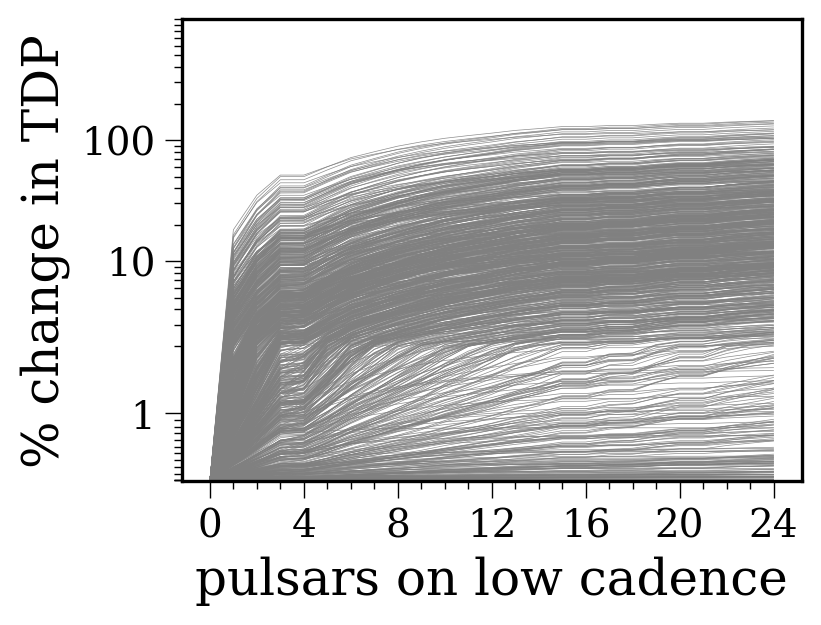

In [254]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, zorder=1)
xtix = np.arange(0,25)
ytix = np.concatenate([[-20],-1*np.linspace(0,1,11), -1*np.linspace(0,10,11), 1*np.linspace(0,1,11), np.linspace(1,10,10), np.linspace(10,100,10), np.linspace(100,1000,10)])
for realization in range(1000):
    plt.plot(np.arange(0,25), 100*((np.array(opt_camp_tdp)[:, realization]-np.array(opt_camp_tdp)[0, realization])/np.array(opt_camp_tdp)[0, realization]),
             alpha=0.9, color='grey', linewidth=0.25)
ax.set_yscale('symlog')
plt.xlabel('pulsars on low cadence', fontsize=18, )
plt.ylabel('% change in TDP', fontsize=18)
plt.yticks([1,10,100],[1,10,100])
plt.yticks(ytix,minor=True )
plt.xticks(xtix, minor=True)
plt.xticks(np.arange(0,25,4))
plt.ylim(bottom=-0.01)
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_change_TDP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()


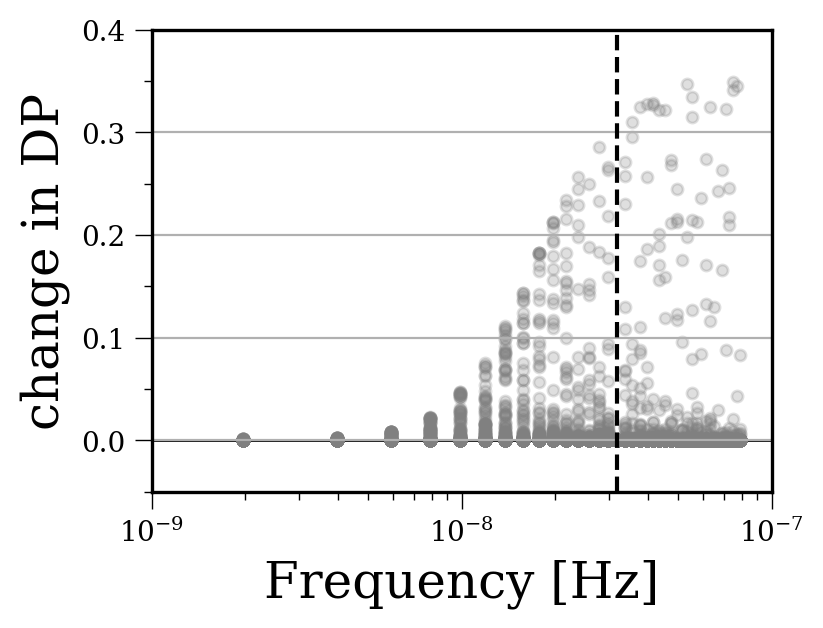

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, zorder=1)
plt.grid(axis='y', alpha=1)
for i in range(1000)[::5]:
    plt.scatter(fobs,(opt_camp_dp[-1,:,i]-opt_camp_dp[0, :, i]), color='grey', alpha=0.25)
plt.xlim(1e-9,1e-7)
plt.axvline(1/(365.25*3600*24), color='k', linestyle='--')
#plt.axvline(3/(10*365.25*24*3600), color='green')
plt.axhline(0, color='k', linewidth=1, zorder=0)
ax.set_xscale('log')
plt.yticks([0,.10, .20, 0.3, 0.4,])
plt.yticks([-.05, 0, .05, .10, .15, .20, .25, 0.35],minor=True )
plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('change in DP', fontsize=18)
#plt.savefig(f'{fig_dir}/MT_treatment_wo_bg_sub_change_DP_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()